References:  
- [1811.12907 ArXiv paper with LIGO plots](https://arxiv.org/pdf/1811.12907.pdf)
- [GWpy tutorials](https://github.com/gw-odw/odw-2020/tree/master/Day_1) [[More tutorials](https://github.com/gw-odw/odw-2020)]
- [LIGO open data workshop](https://www.gw-openscience.org/static/workshop3/)
- [GWpy signal filtering](https://gwpy.github.io/docs/stable/examples/signal/gw150914.html)

## Install Required Libraries:

- gwpy for Gravitational Wave analysis
- joypy for joy division style plots

Import libraries:
- `requests` to download data files
- `os` to access files saved in the local folder
- `pandas` to work with dataframes
- `numpy` to define arrays and do math
- `matplotlib` for graphs


Import Class `TimeSeries` to store & process LIGO data.

In [327]:
import requests, os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


from gwpy.timeseries import TimeSeriesDict
from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design


To import the Neutron Star and Black Hole collison data, we downloaded a `.csv` file from

 https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/

 To that `.csv` we appended a couple of _off catalogue_ but notable events:

 https://www.gw-openscience.org/eventapi/html/O3_Discovery_Papers/

The file is in our shared keybase folder, and should be uploaded to the local colab folder.

## Idea:

By importing the `csv` file we can associate the event name wich each GPS time.



In [328]:
ligo_events = pd.read_csv('LIGO-Events-of-Interest.csv')
ligo_events.shape # how many events

# keep the two columns we need
name_n_time = ligo_events[["commonName", "GPS"]]

In [329]:
# round the Unix Timestamp so it has no decimals
# ignore warning
name_n_time["GPS"] = name_n_time["GPS"].apply(lambda x : round(x))

#-- Choose detector as H1, L1, or V1
detector = ['H1','L1','V1'] #Hanford, Livinston, Virgo

<ipython-input-329-ccddd9411b90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_n_time["GPS"] = name_n_time["GPS"].apply(lambda x : round(x))


In [330]:
# Turn it into a key-value store (dictionary)
events_name_n_time = {}
for x in name_n_time.iterrows():
  di_name = x[1][0]
  di_time = x[1][1]
  events_name_n_time[di_time] = di_name

# events_name_n_time

## I've commented out downloads (as they are already done!)


In [331]:
from gwosc.locate import get_urls
full_event_list = []

for t0 in events_name_n_time: # loop over GPS times of events
  event_name = events_name_n_time[t0]
  print(event_name)
  for lab in detector:
    # keep in the list, the URL, the time, the name and the lab
    # the index "0" after get_urls(a,b,c)[0] selects the 32s files
    # index 1 selects a very long (and many MB) dataset
    try: # try to get data
        event_url = get_urls(lab,t0,t0)[0]
        full_event_list.append([event_url, event_name, t0, lab])
    except Exception as e: # if data is not there (Virgo did not have it)
        print(lab, ' data not available: ',e )
'''
for event_url in full_event_list:
  fn = "ligodata/{}-{}-{}.hdf5".format(event_url[1], event_url[2], event_url[3])
  with open(fn,'wb') as strainfile:                 
    straindata = requests.get(event_url[0]) # <-- remove comment to download
    print("Downloading ", fn)
    strainfile.write(straindata.content)  # <-- remove comment to download
'''


GW150914
V1  data not available:  Cannot find a LOSC dataset for V1 covering [1126259462, 1126259462)
GW151012
V1  data not available:  Cannot find a LOSC dataset for V1 covering [1128678900, 1128678900)
GW151226
V1  data not available:  Cannot find a LOSC dataset for V1 covering [1135136351, 1135136351)
GW170104
V1  data not available:  Cannot find a LOSC dataset for V1 covering [1167559937, 1167559937)
GW170608
V1  data not available:  Cannot find a LOSC dataset for V1 covering [1180922494, 1180922494)
GW170729
GW170809
GW170814
GW170817
GW170818
GW170823
GW190412
GW190521
GW190814


'\nfor event_url in full_event_list:\n  fn = "ligodata/{}-{}-{}.hdf5".format(event_url[1], event_url[2], event_url[3])\n  with open(fn,\'wb\') as strainfile:                 \n    straindata = requests.get(event_url[0]) # <-- remove comment to download\n    print("Downloading ", fn)\n    strainfile.write(straindata.content)  # <-- remove comment to download\n'

# Plotting subset of noisy data:
(Running this is optional)

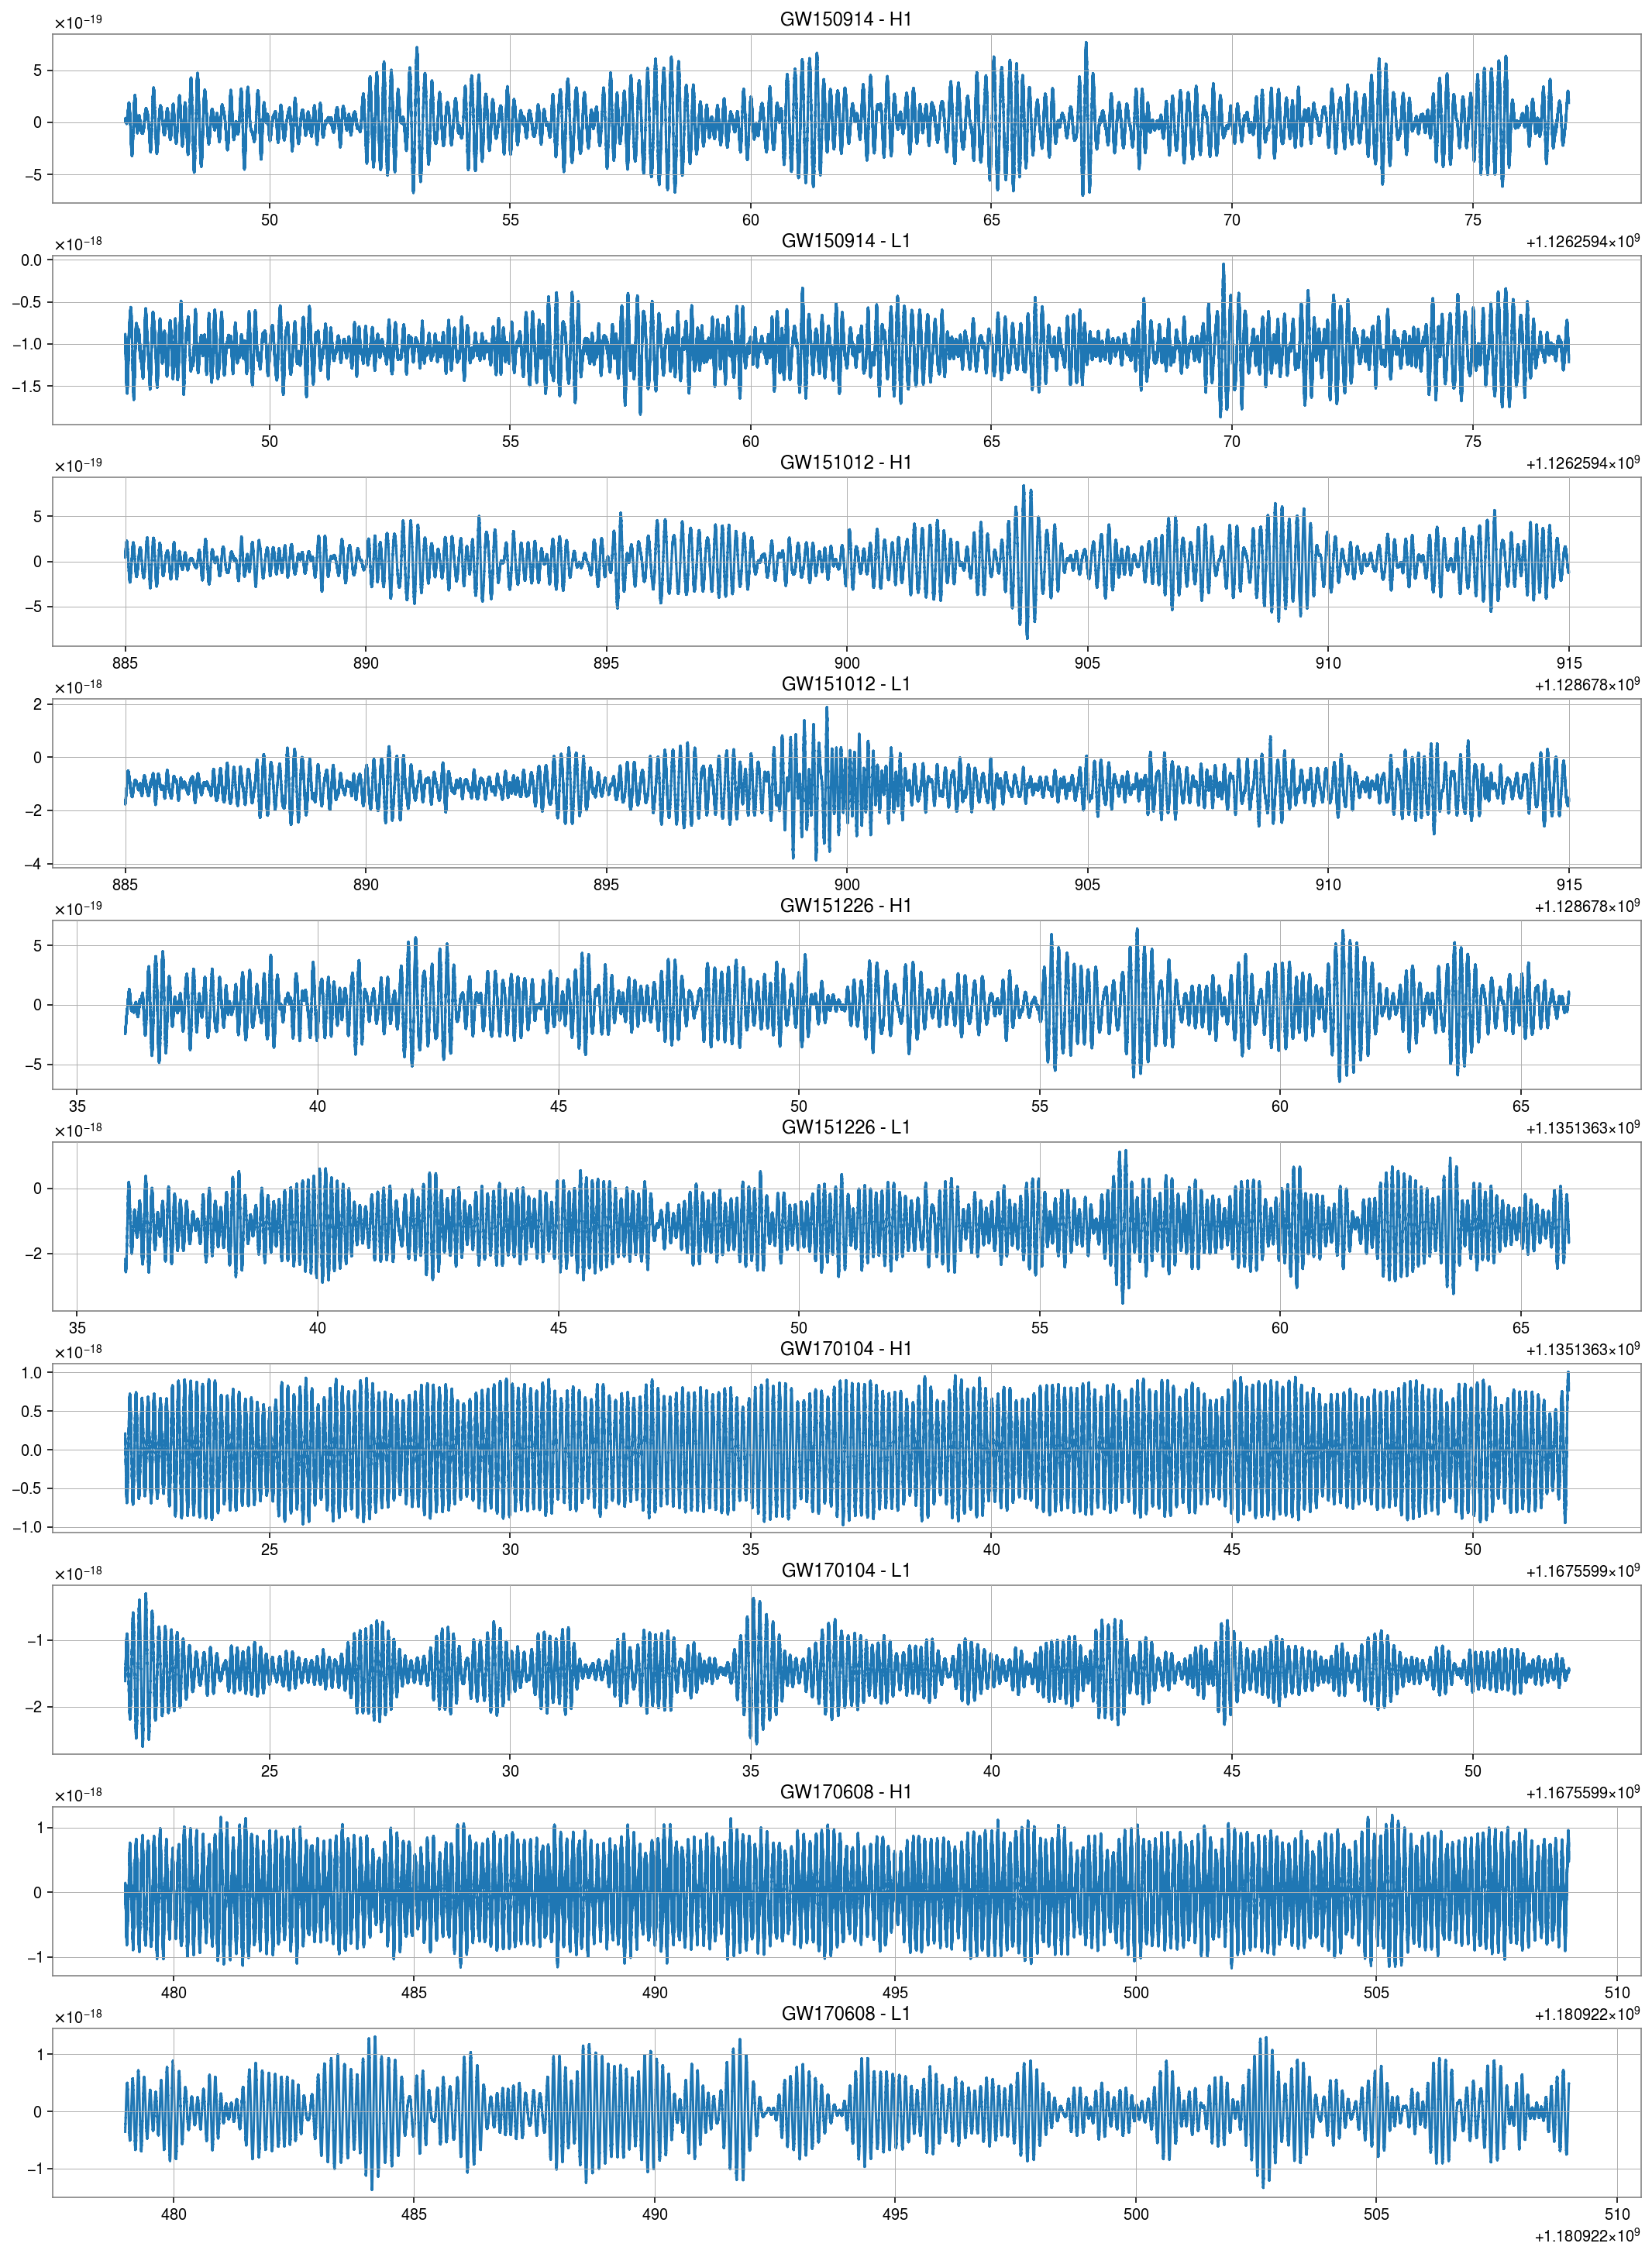

In [332]:
# Let's plot a subset of the data 


fig, ax = plt.subplots(10, figsize=(15,20))
fig.tight_layout(pad=1.0)

ind = 0

for ev in full_event_list[:10]:
  fn = "./ligodata/{}-{}-{}.hdf5".format(ev[1], ev[2], ev[3])
  strain = TimeSeries.read(fn,format='hdf5.losc' ) 
  center = int(ev[2])
  strain = strain.crop(center-15, center+15)
  ax[ind].plot(strain)
  ax[ind].title.set_text(ev[1] + ' - ' + ev[3]) # title is event & lab
  ind = ind + 1
    

## Whiten & Bandpass -> Plot
(just exploration, Optional)

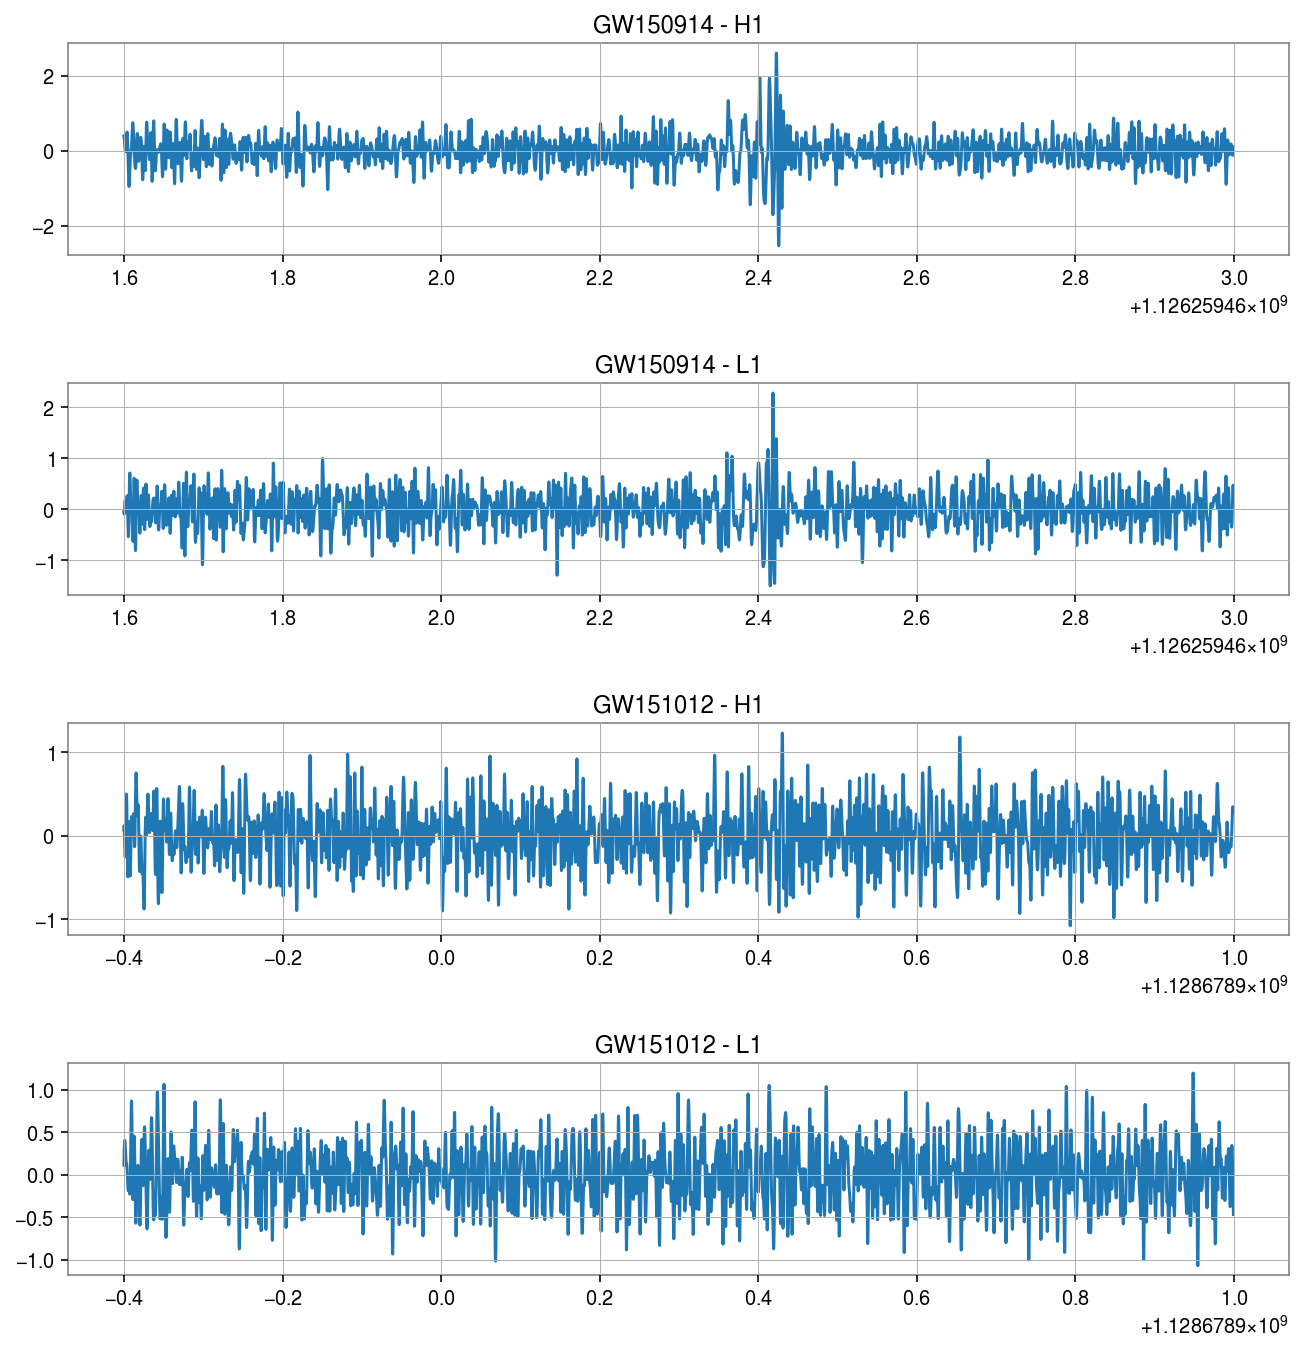

In [333]:

nr_plots = 4

fig, ax = plt.subplots(nr_plots, figsize=(10,10))
fig.tight_layout(pad=4.0)



for ind, ev in enumerate(full_event_list[:nr_plots]):
  fn = "ligodata/{}-{}-{}.hdf5".format(ev[1], ev[2], ev[3])
  strain = TimeSeries.read(fn,format='hdf5.losc' ) 
  white_data = strain.whiten()
  bp_data = white_data.bandpass(35, 350) # https://arxiv.org/pdf/1903.00546.pdf
  
  center = int(ev[2])
  cropped_bp = bp_data.crop(center-0.4, center+1)
  ax[ind].plot(cropped_bp)
  ax[ind].title.set_text(ev[1] + ' - ' + ev[3]) # title is event & lab
  ind = ind + 1

  

# Data Cleaning Strategy

Each event may have different high/low frequency filters, 
and may not be exactly centered around the "center"time.
Therefore, we will investigate & filter each event one by one
to obtain the best looking possible plot each time.

### Strategy 1: Use bandpass + whiten simply

### Strategy 2: Use instructions [here](https://gwpy.github.io/docs/stable/examples/signal/gw150914.html) (now function `clean_it_up()`)

Filtering Function:

In [334]:
def clean_it_up(event_index, full_event_list, low_bandpass, high_bandpass):
    '''
    Cleans up 
    # based on: https://gwpy.github.io/docs/stable/examples/signal/gw150914.html
    :event_index int: chose event_index (a number between 0 and full_event_list)
    :full_event_list list: defined further up this notebook
    :low_bandpass int: lower cut for frequencies (typically 30Hz - 50Hz)
    :high_bandpass int: higher cut for frequencies (typically 200Hz - 300Hz)
    :grid_frequency int: frequency of electrical grid (which induces noise in signal), 50Hz Europe, 60Hz US
    :return: filt_strain (a filtered TimeSeries object)
    
    '''
    ev = full_event_list[event_index]
    
    # chose file
    fn = "ligodata/{}-{}-{}.hdf5".format(ev[1], ev[2], ev[3])
    # get strain from file
    strain = TimeSeries.read(fn,format='hdf5.losc' )
    # banspass
    bp = filter_design.bandpass(low_bandpass, high_bandpass, strain.sample_rate)
    # remove electrical noise 60Hz
    lab = ev[3]
    if lab == 'H1' or lab == 'L1': # US lab
        notches = [filter_design.notch(line, strain.sample_rate) for \
           line in (59, 59.5, 60, 60.5, 61, 120, 180, 240)]
    if lab == 'V1': # EU Lab
        notches = [filter_design.notch(line, strain.sample_rate) for \
           line in (49, 49.5, 50, 50.5, 51, 98, 99, 100,101,102, 148, 149, 150, 151, 152, 200)]

    zpk = filter_design.concatenate_zpks(bp, *notches)
    filt_strain = strain.filter(zpk, filtfilt=True)

    filt_strain = filt_strain.crop(*filt_strain.span.contract(1))

    return filt_strain




In [335]:
def plot_strain(event_index, full_event_list, strain_timeseries, delta_L, delta_R):
    '''
    plot a filtered strain timeseries, and constrain the x-axis
    :event_index int: chose event_index (a number between 0 and full_event_list)
    :full_event_list list: defined further up this notebook
    :strain_timeseries TimeSeries() object: from gwpy
    :delta_L float: how far left from the center of the event to plot 
       (max of 16, since the whole time series is 32s long, 
       can be negative to move right of center)
    :delta_R float: how far right from the center of the event to plot 
    '''
    ev = full_event_list[event_index]
    lab = ev[3]
    event_name = ev[1]
    time_stamp = ev[2]

    if lab =='H1':
        colour = 'gwpy:ligo-hanford'
    if lab == 'L1':
        colour = 'gwpy:ligo-livingston'
    if lab == 'V1':
        colour = 'green'

    from gwpy.plot import Plot
    plot = Plot(strain_timeseries, figsize=[16,2.5], color=colour )
    ax = plot.axes[0]
    ax.set_title(event_name + ' - ' + lab)
    ax.set_ylabel('Amplitude [strain]')
    ax.set_xlim(time_stamp - delta_L, time_stamp + delta_R)
    ax.set_xscale('seconds', epoch=time_stamp)
    print("INTERVAL IS: ", delta_R + delta_L)

    return delta_L, delta_R

    plot.show()        

#### ✓ GW150914 H1 & L1

In [336]:
mi = [0.13, 0.7] # <- small
me = [-0.925,-0.32] # <- big = 1.5x 

translate_left_point = -0.925-0.13
stretch_length = (0.7-0.13)/(-0.926+0.325)

In [337]:
translate_left_point, stretch_length

(-1.0550000000000002, -0.9484193011647254)

In [338]:
the_interesting_data = []

INTERVAL IS:  0.75
INTERVAL IS:  0.75


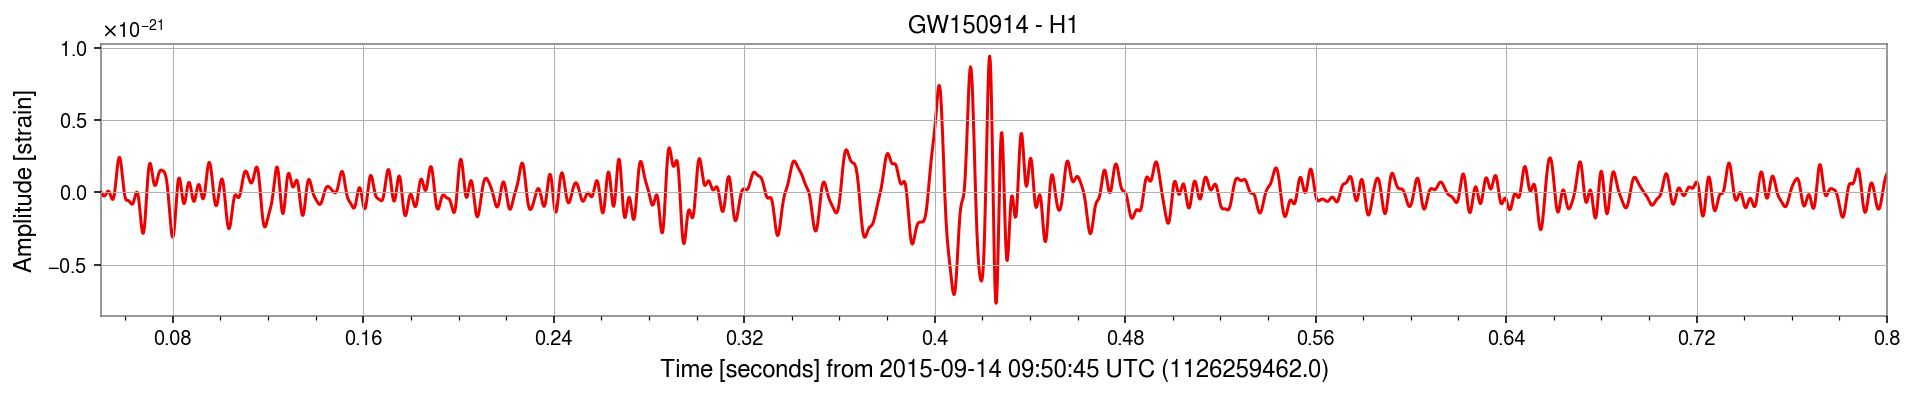

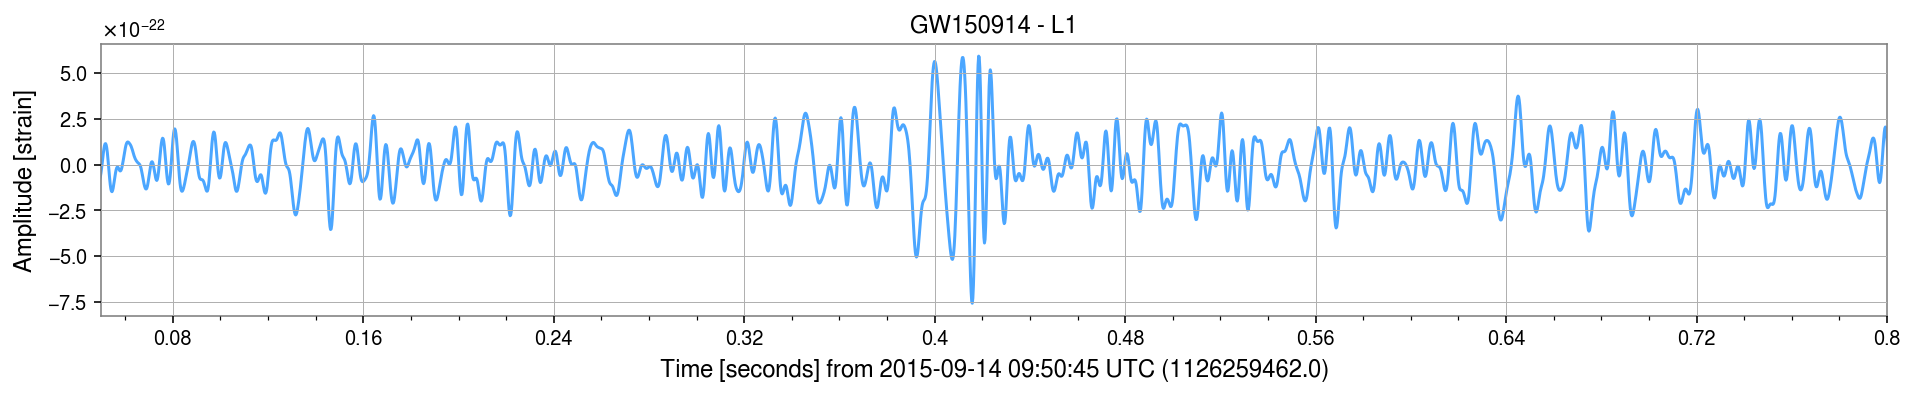

In [339]:
for i in [0,1]:
    s1 = clean_it_up(i, full_event_list, 50, 250)
    L,R = plot_strain(i, full_event_list, s1, -0.05, 0.8)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])


In [340]:
%%script false --no-raise-error  # <<--- IGNORE THIS CELL
%matplotlib inline
half_way = int(len(s1)/2)
one_sec = int(len(s1)/32)

L = (1.055-0.13)*(one_sec)
R = (0.7-1.05)*(one_sec)

interval = [int(half_way - L), int(half_way + R)]


# print(len(s1)/2, len(s1)/32, half_way, one_sec, half_way-L,half_way+R, interval)

plt.figure(figsize=(16,2.5))
# plt.plot(s1[61939:64128])
plt.plot(s1[interval[0]:interval[1]])

In [341]:
%%script false --no-raise-error  # <<--- IGNORE THIS CELL
from gwpy.plot import Plot
plot = Plot(s1[interval[0]:interval[1]], figsize=[16,2.5] )
ax = plot.axes[0]
ax.set_title(event_name + ' - ' + lab)
plot.show()

#### ✓ GW151012 H1 & L1

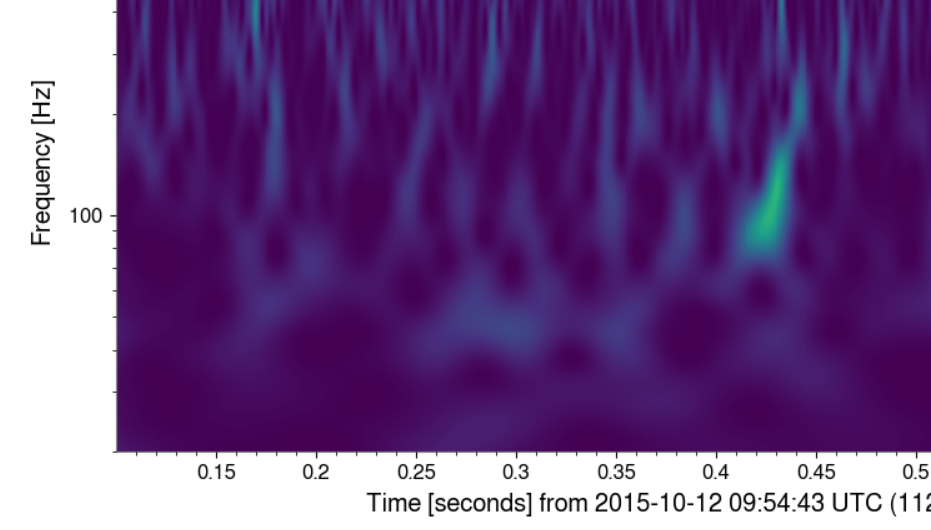

INTERVAL IS:  0.49999999999999994
INTERVAL IS:  0.49999999999999994


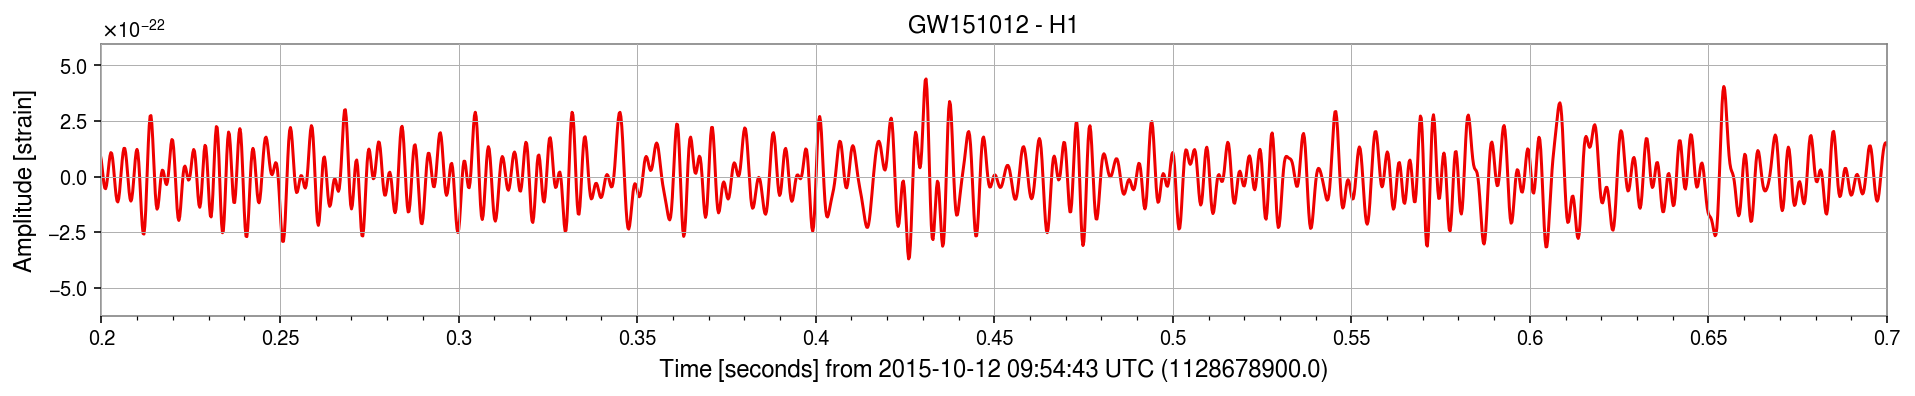

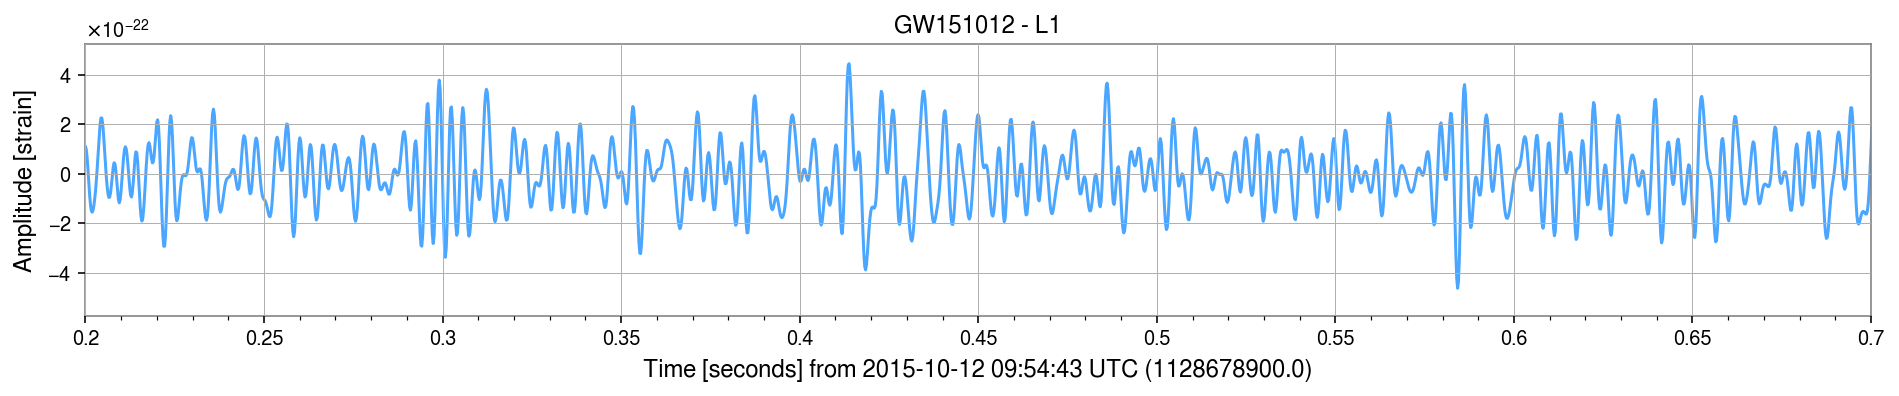

In [342]:
for i in [2,3]:
    s1 = clean_it_up(i, full_event_list, 75, 310) #70, 310
    L,R = plot_strain(i, full_event_list, s1, -0.2, 0.7) # -0.26, 0.6

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])


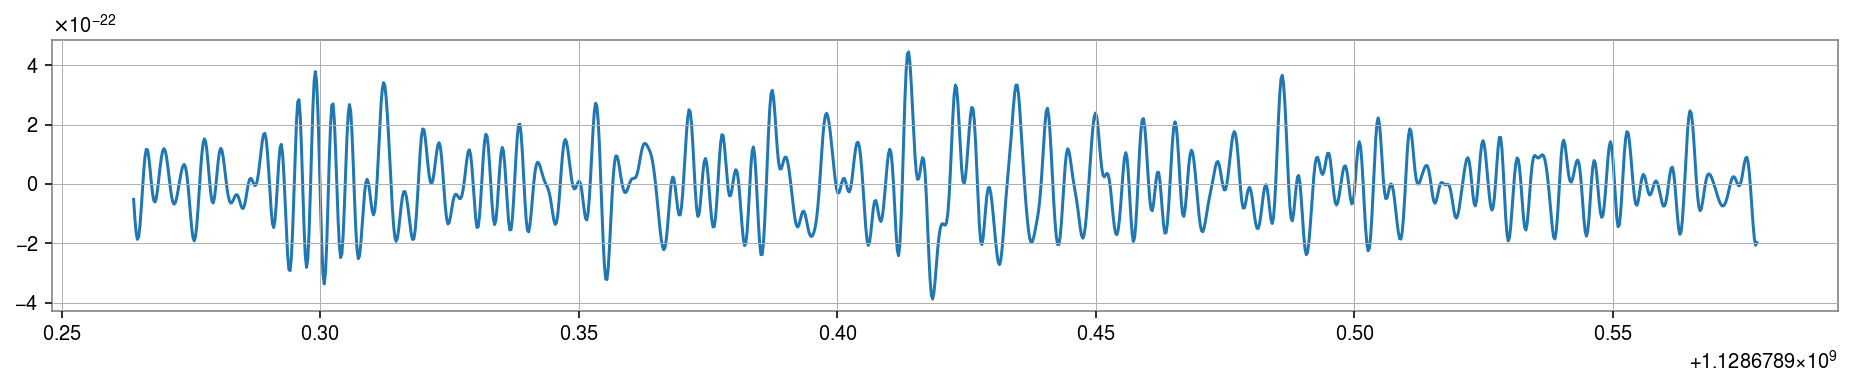

In [343]:
%matplotlib inline
half_way = int(len(s1)/2)
one_sec = int(len(s1)/32)

L = (1.055-0.27)*(one_sec)
R = (0.60-1.05)*(one_sec)

interval = [int(half_way - L), int(half_way + R)]


# print(len(s1)/2, len(s1)/32, half_way, one_sec, half_way-L,half_way+R, interval)

plt.figure(figsize=(16,2.5))
# plt.plot(s1[61939:64128])
plt.plot(s1[interval[0]:interval[1]])

#### ✓ GW151226 H1 & L1
https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW151226/v2/

INTERVAL IS:  0.5
INTERVAL IS:  0.5


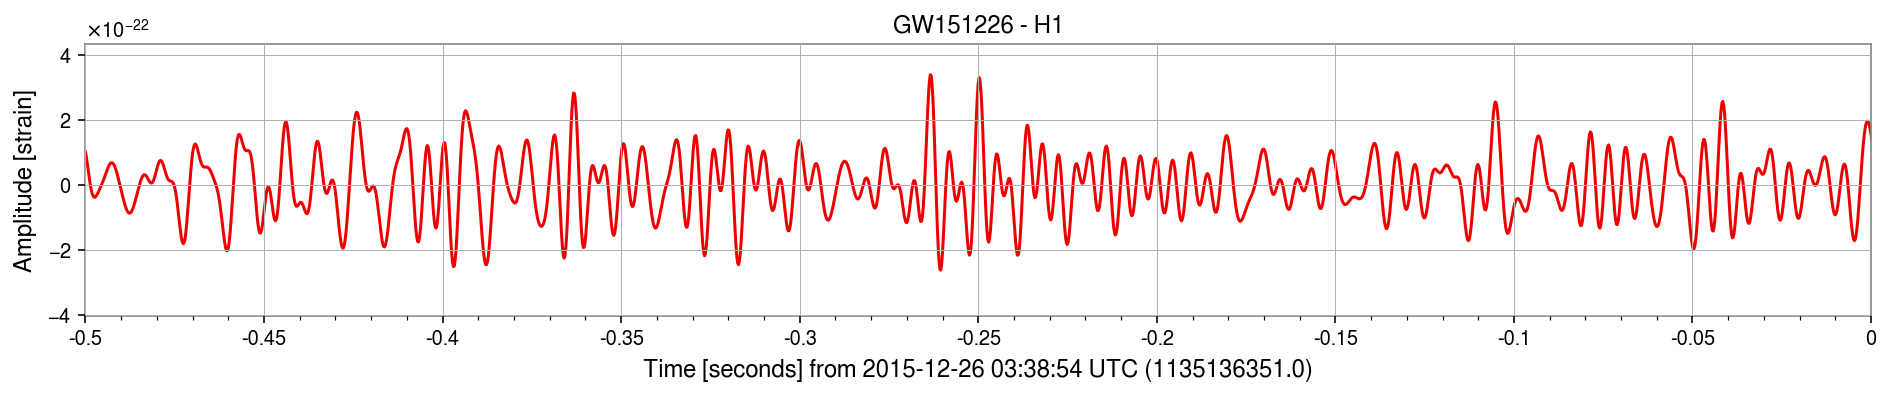

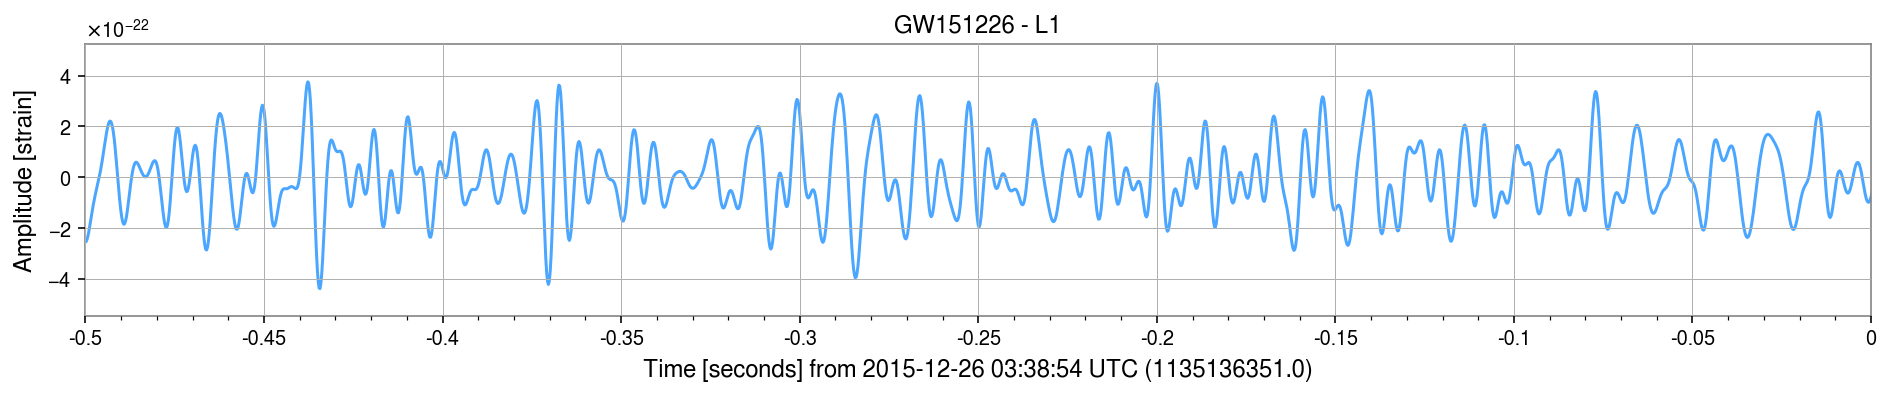

In [344]:
for i in [4,5]:
    s1 = clean_it_up(i, full_event_list, 60,230)  # 60, 230)
    L,R = plot_strain(i, full_event_list, s1, 0.5, 0)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170104 H1 & L1
[image.png](attachment:image.png)

INTERVAL IS:  0.58
INTERVAL IS:  0.58


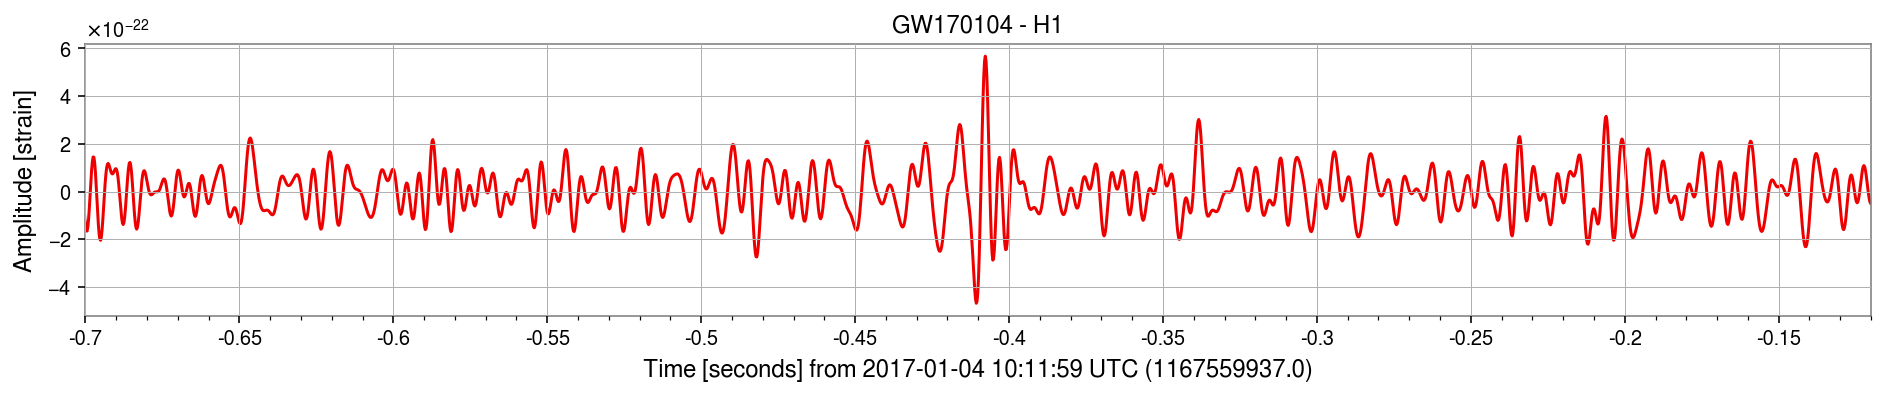

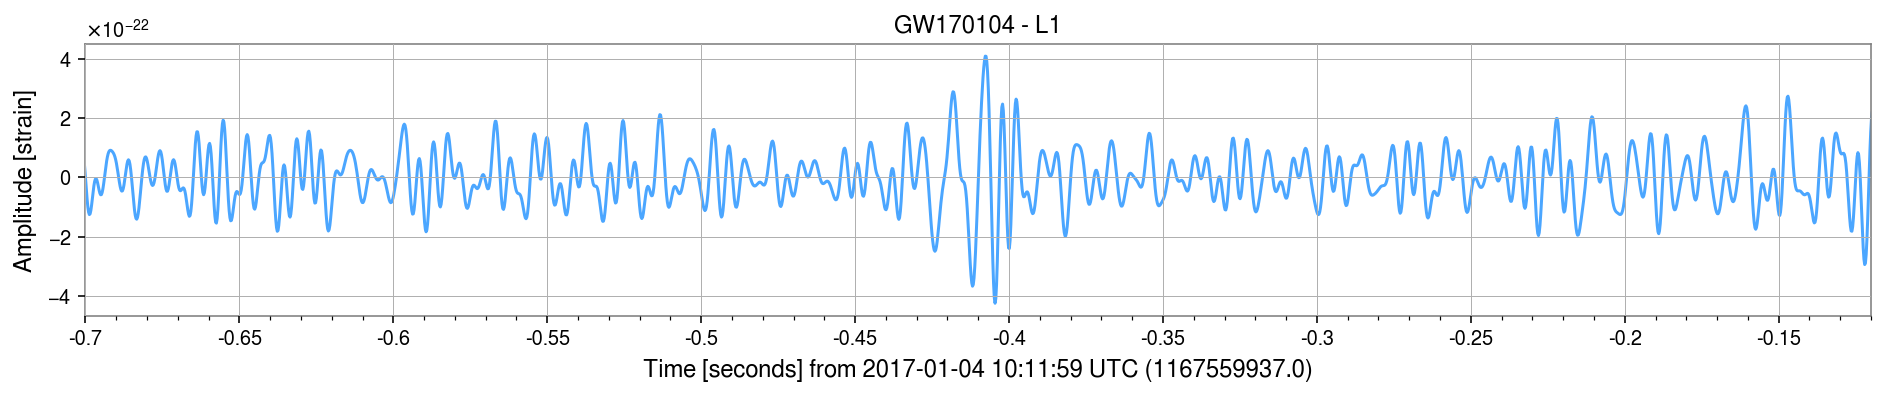

In [345]:
for i in [6,7]:
    s1 = clean_it_up(i, full_event_list, 60, 260)
    L,R = plot_strain(i, full_event_list, s1, 0.7, -0.12)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170608 H1 & L1
[image.png](attachment:image.png)

INTERVAL IS:  0.65
INTERVAL IS:  0.65


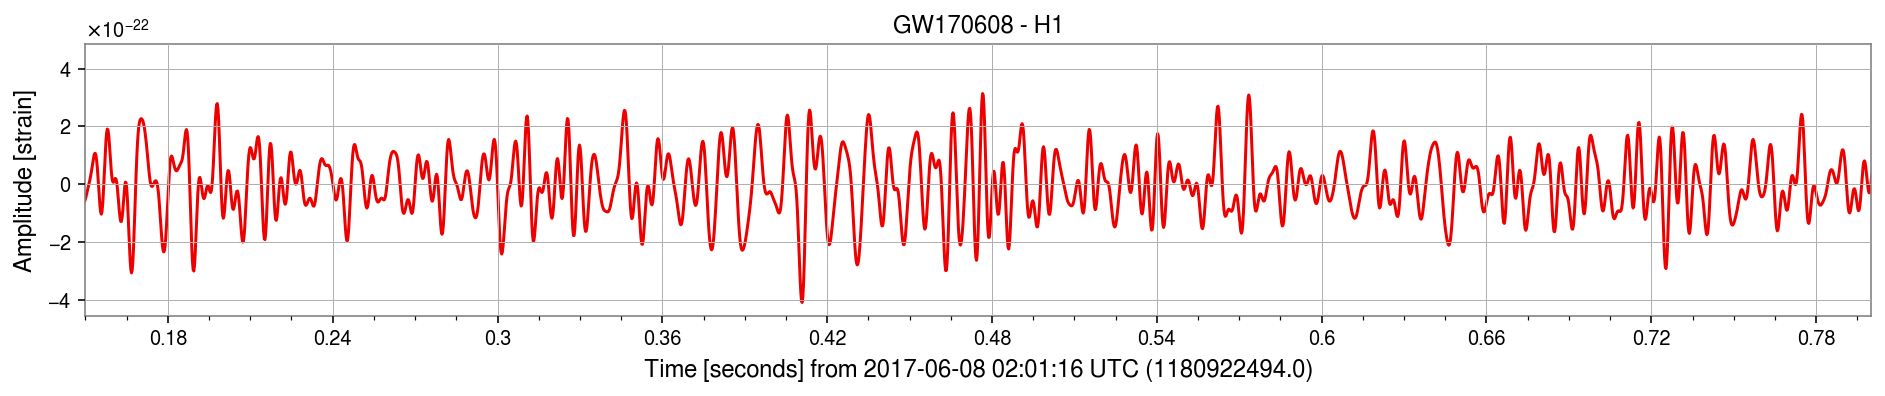

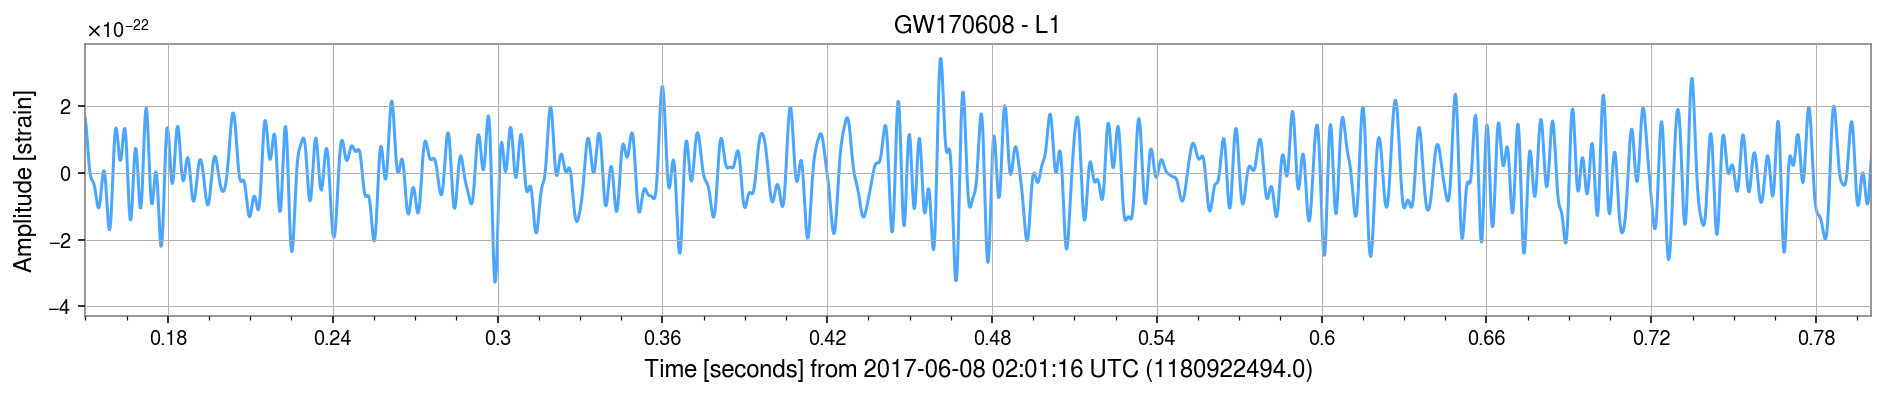

In [346]:
for i in [8,9]:
    s1 = clean_it_up(i, full_event_list, 50, 280) # 56, 180
    L,R = plot_strain(i, full_event_list, s1, -0.15, 0.8) # 0.15, 1

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170729 H1, L1 & V1

INTERVAL IS:  0.37
INTERVAL IS:  0.37


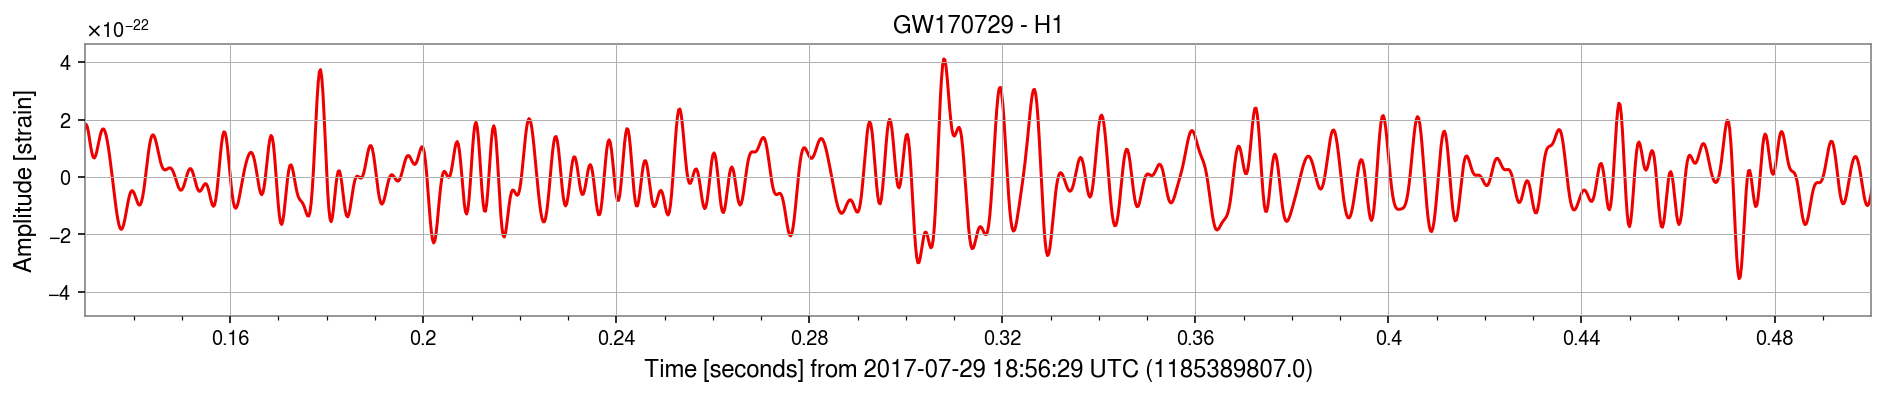

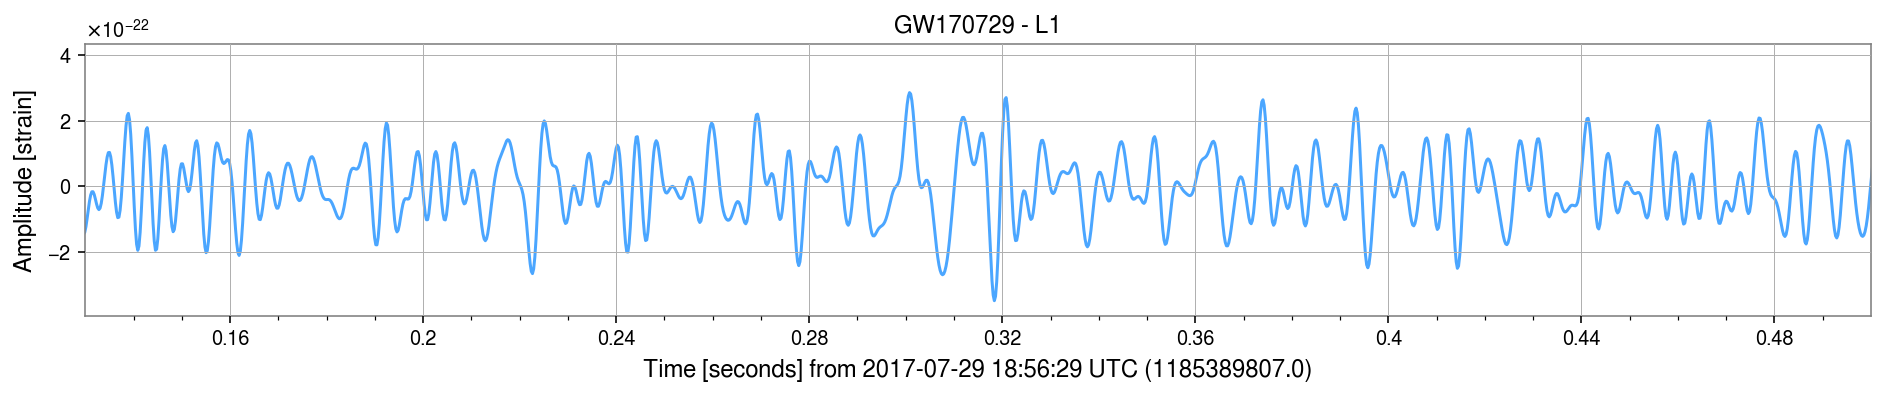

In [347]:
for i in [10,11]:
    s1 = clean_it_up(i, full_event_list, 60, 300)
    L,R = plot_strain(i, full_event_list, s1, -0.13, 0.5)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

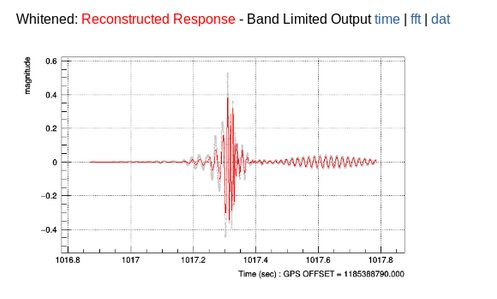
sauce: https://gwburst.gitlab.io/info/gw170729_ced_gwosc/

INTERVAL IS:  9.5


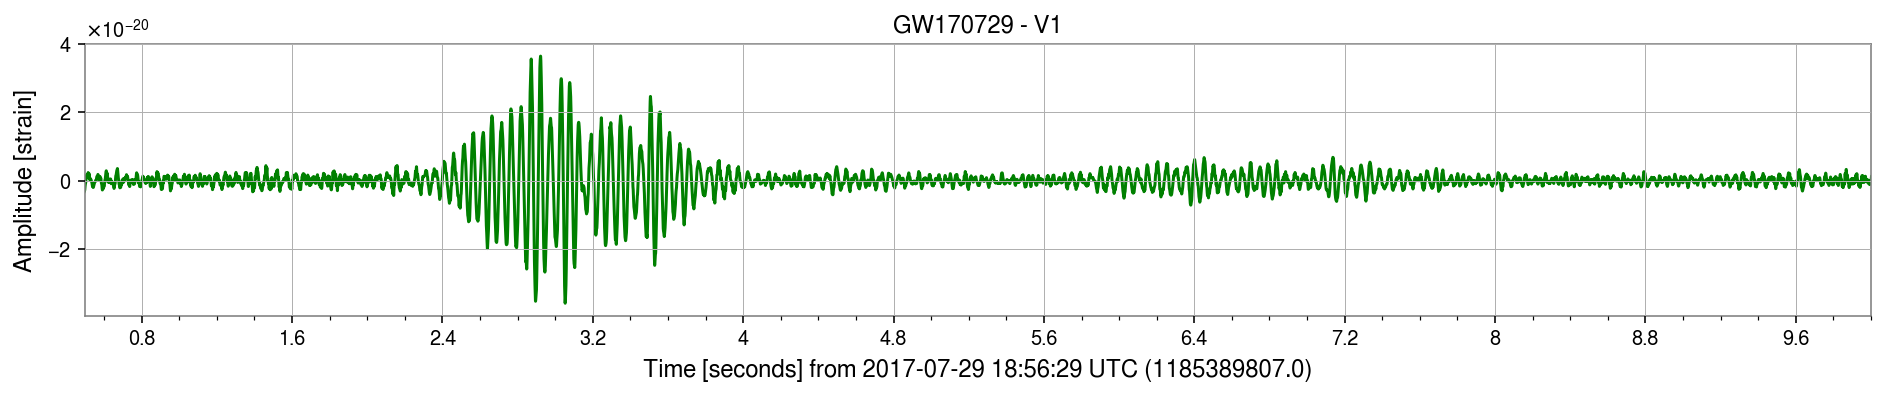

In [348]:
for i in [12]:
    s1 = clean_it_up(i, full_event_list, 19, 220) # 19, 250
    L,R = plot_strain(i, full_event_list, s1, -0.5, 10) #-0.5, 5
    
    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170809 H1, L1 & V1
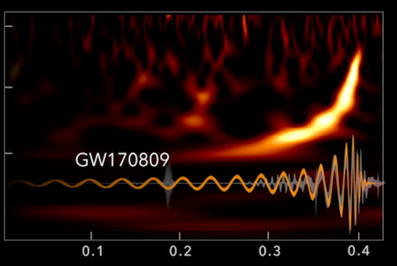

INTERVAL IS:  0.48
INTERVAL IS:  0.48


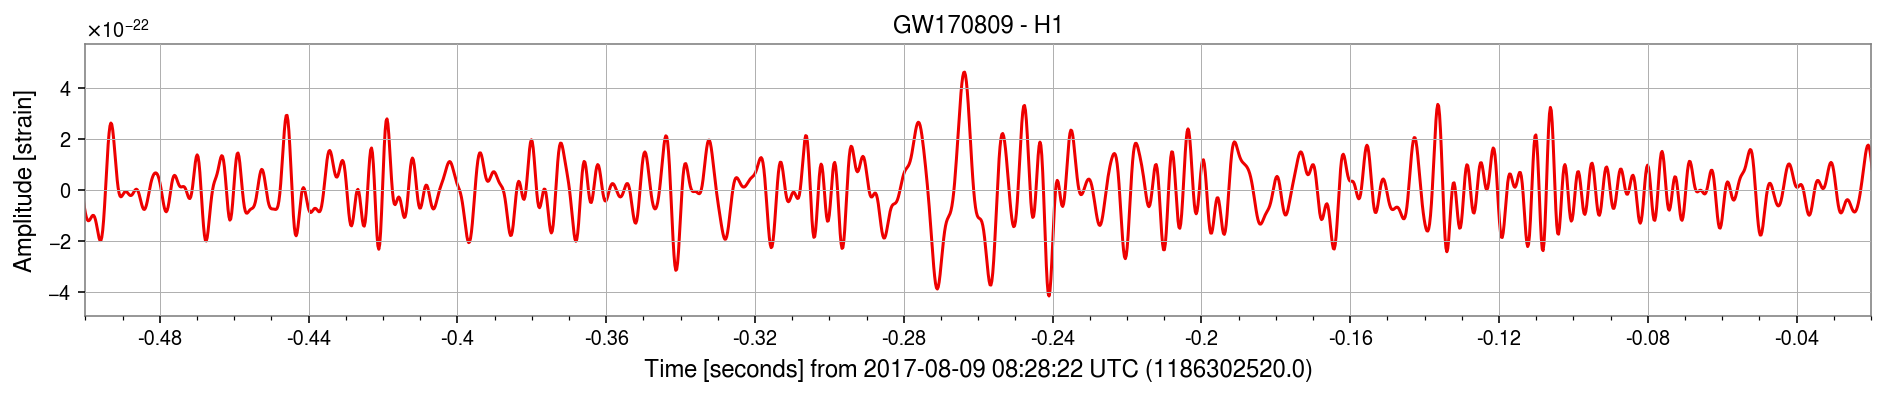

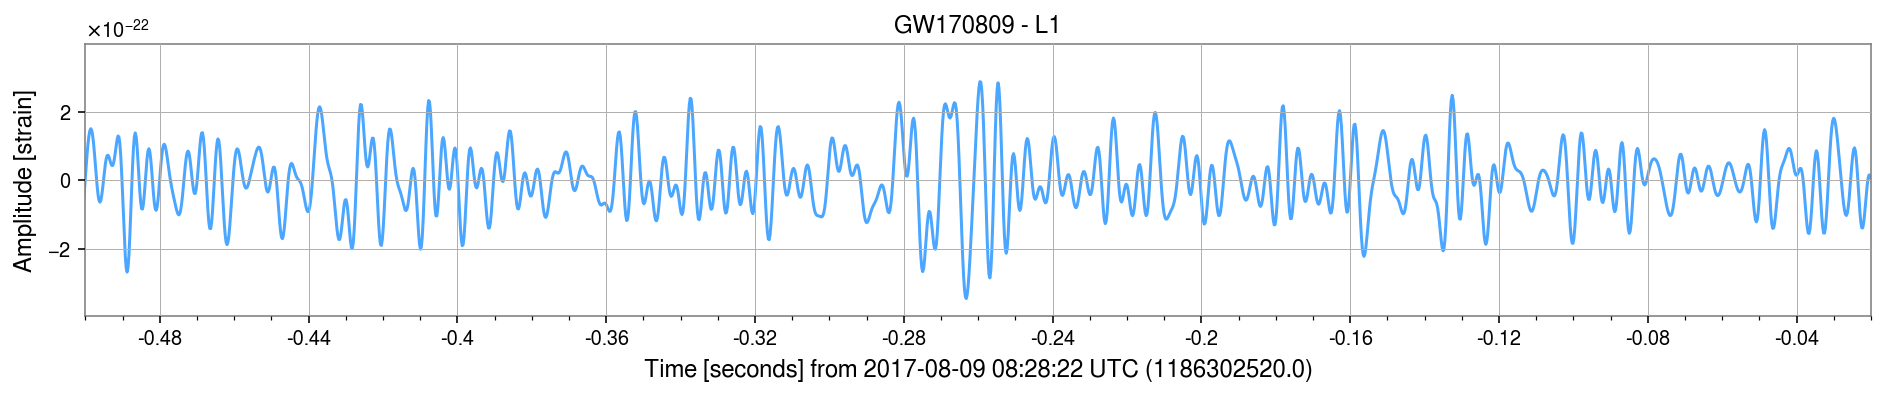

In [349]:
for i in [13,14]:
    s1 = clean_it_up(i, full_event_list, 56, 280)
    L,R = plot_strain(i, full_event_list, s1, 0.5, -0.02)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

INTERVAL IS:  0.8999999999999986


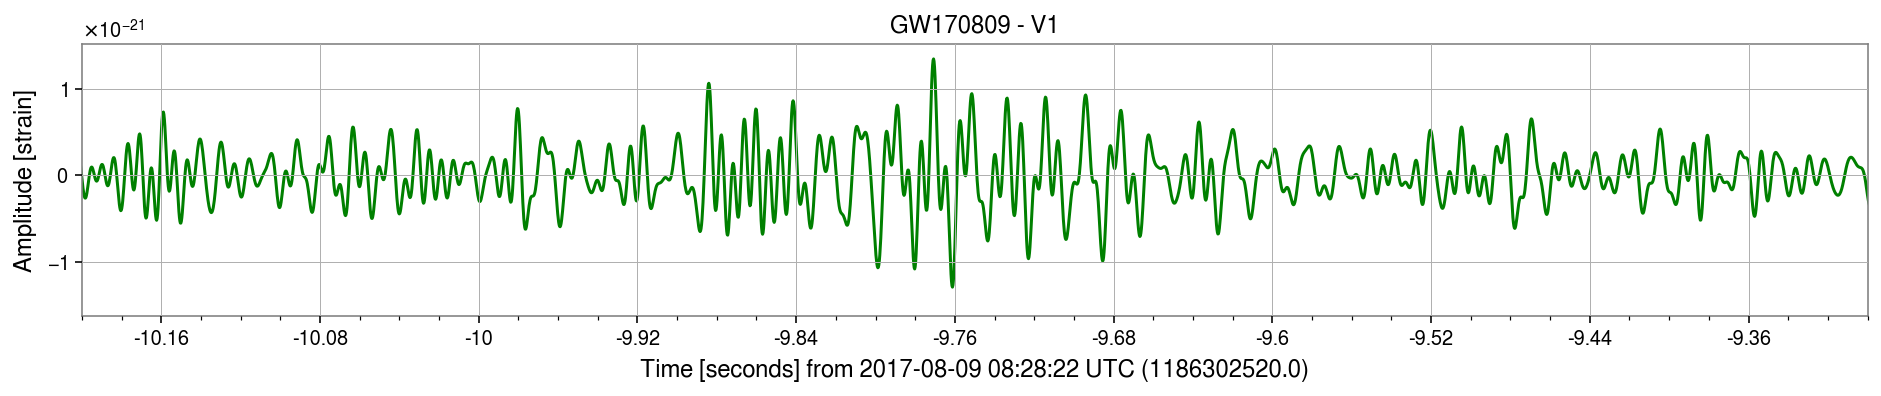

In [350]:
for i in [15]:
    s1 = clean_it_up(i, full_event_list, 50, 180)
    L,R = plot_strain(i, full_event_list, s1, 10.2, -9.3) # 10.5, -9.3

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170814 L1 & V1
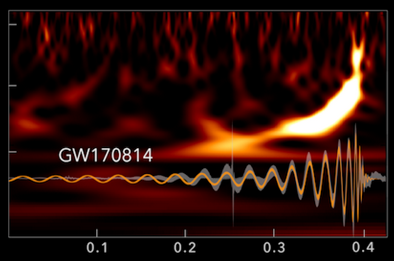

INTERVAL IS:  0.4500000000000002


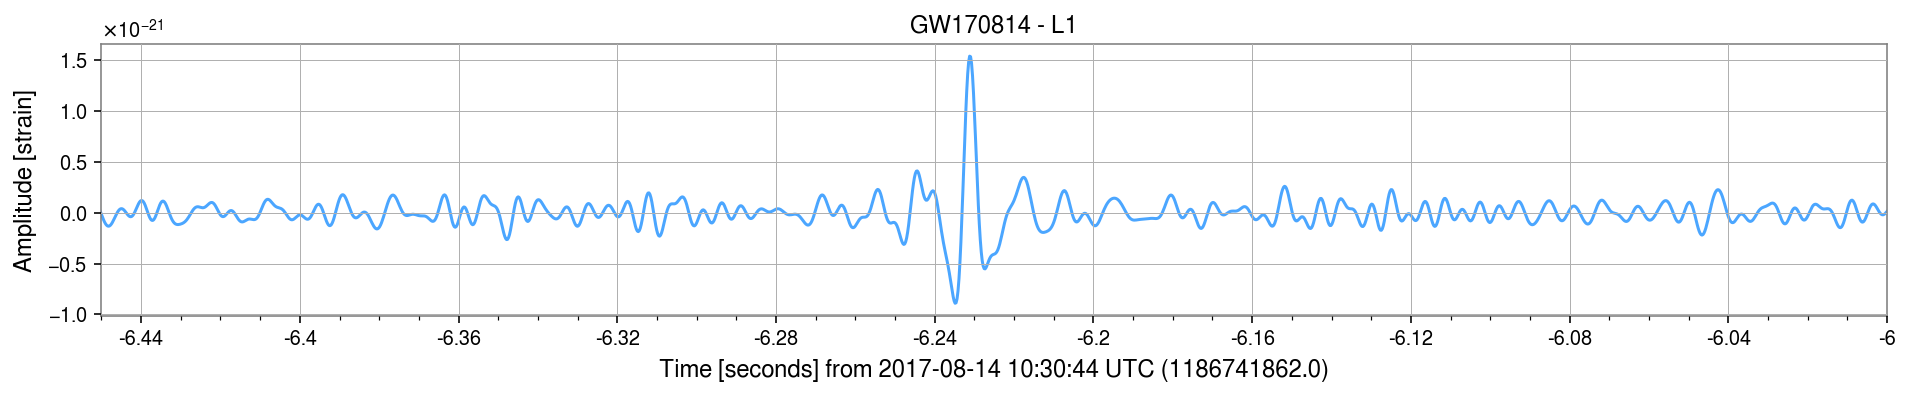

In [351]:
for i in [17]:
    s1 = clean_it_up(i, full_event_list, 56, 230)
    L,R = plot_strain(i, full_event_list, s1, 6.45, -6)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

INTERVAL IS:  1.2999999999999998


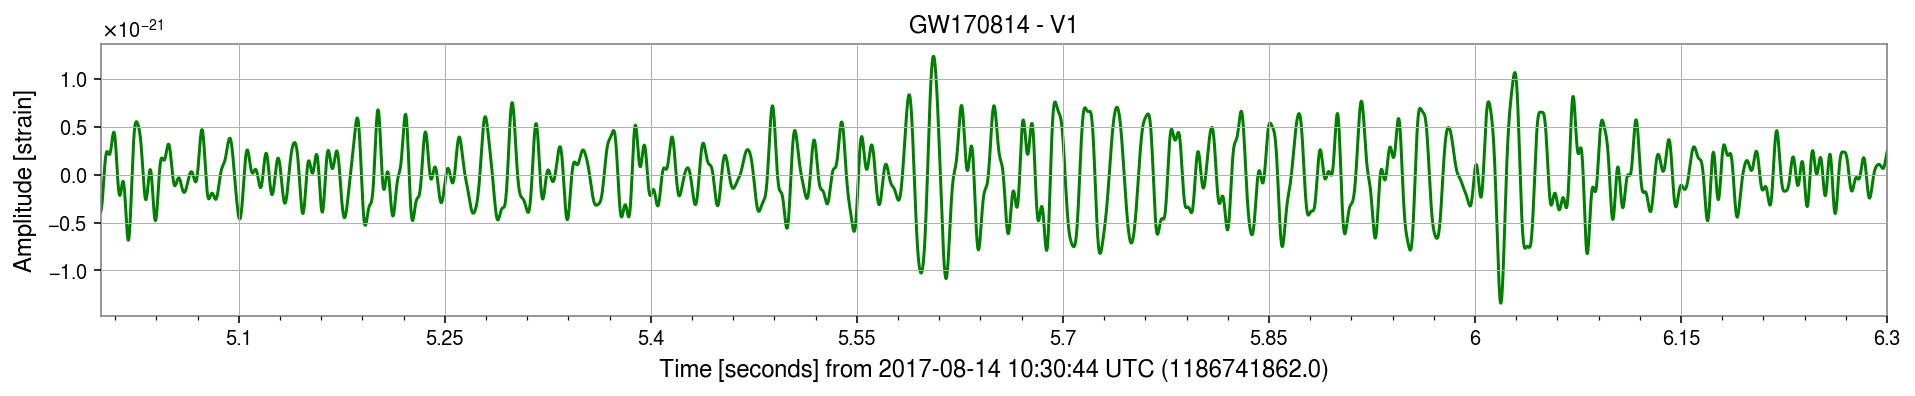

In [352]:
for i in [18]:
    s1 = clean_it_up(i, full_event_list, 44, 150) # 40, 130
    L,R = plot_strain(i, full_event_list, s1, -5, 6.3)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170817 L1 & V1
[image.png](attachment:image.png)

INTERVAL IS:  0.54


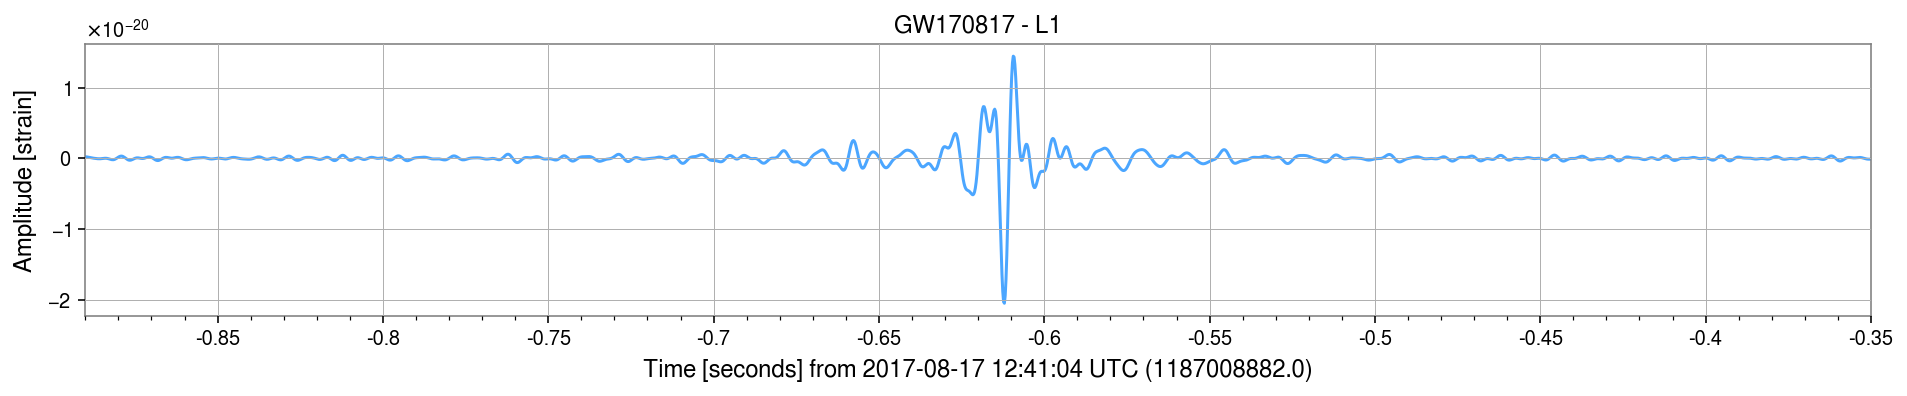

In [353]:
for i in [20]:
    s1 = clean_it_up(i, full_event_list, 80, 250)
    plot_strain(i, full_event_list, s1, 0.89, -0.35)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

INTERVAL IS:  0.8499999999999999


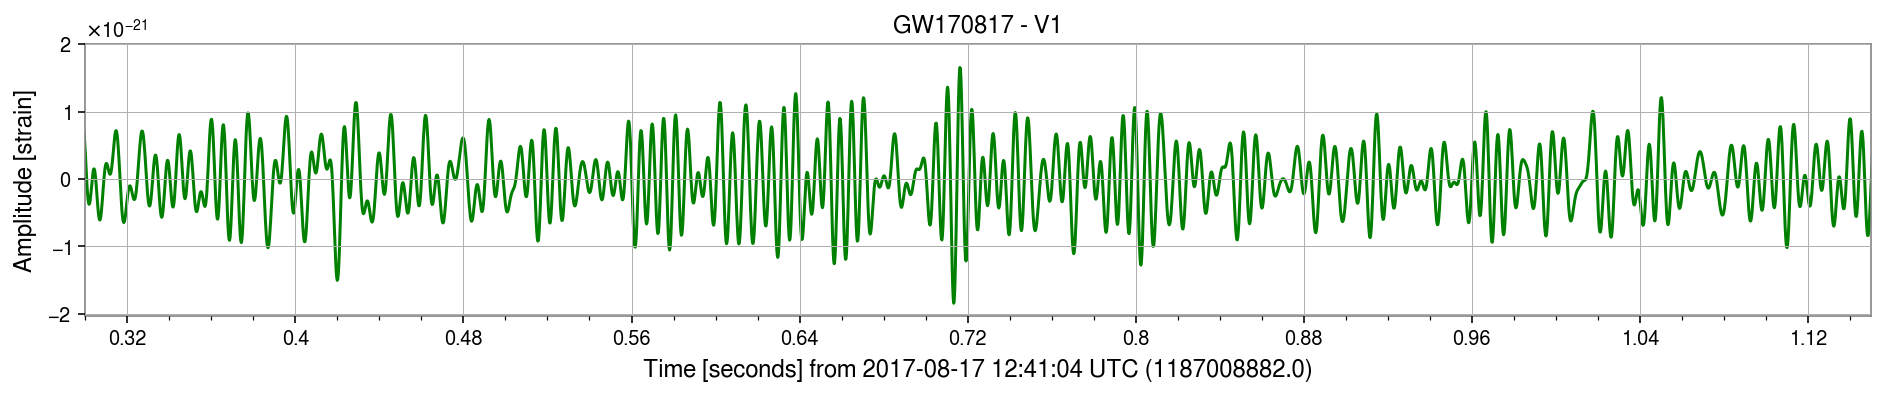

In [354]:
for i in [21]:
    s1 = clean_it_up(i, full_event_list, 56, 190)
    L,R = plot_strain(i, full_event_list, s1, -0.3, 1.15)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW170818 L1 & V1

INTERVAL IS:  1.0


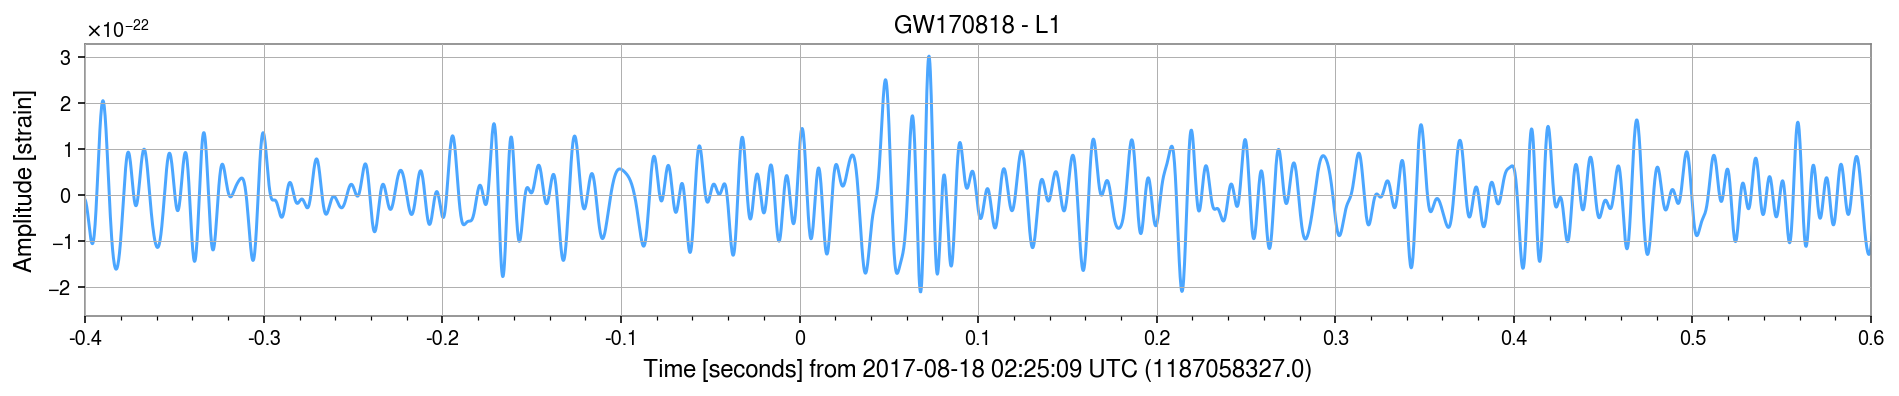

In [355]:
for i in [23]:
    s1 = clean_it_up(i, full_event_list, 40, 130)
    L,R = plot_strain(i, full_event_list, s1, 0.4, 0.6)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

INTERVAL IS:  0.9000000000000004


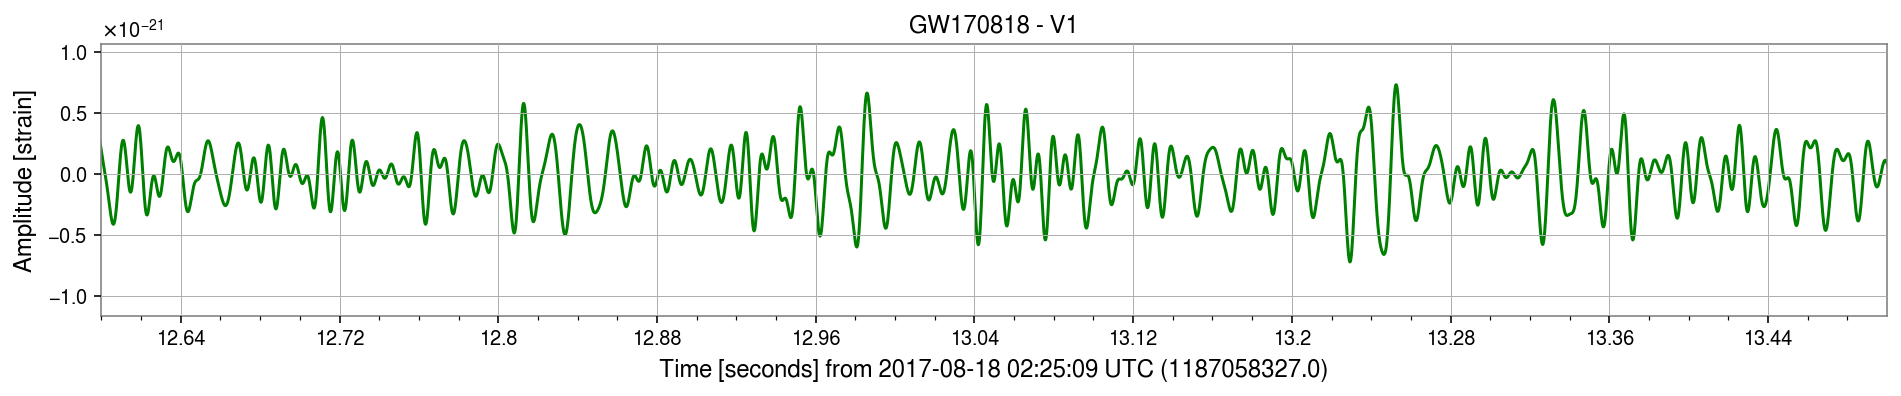

In [356]:
for i in [24]:
    s1 = clean_it_up(i, full_event_list, 50, 150)
    L,R = plot_strain(i, full_event_list, s1, -12.6, 13.5)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW190412 H1 & L1

INTERVAL IS:  0.8
INTERVAL IS:  0.8


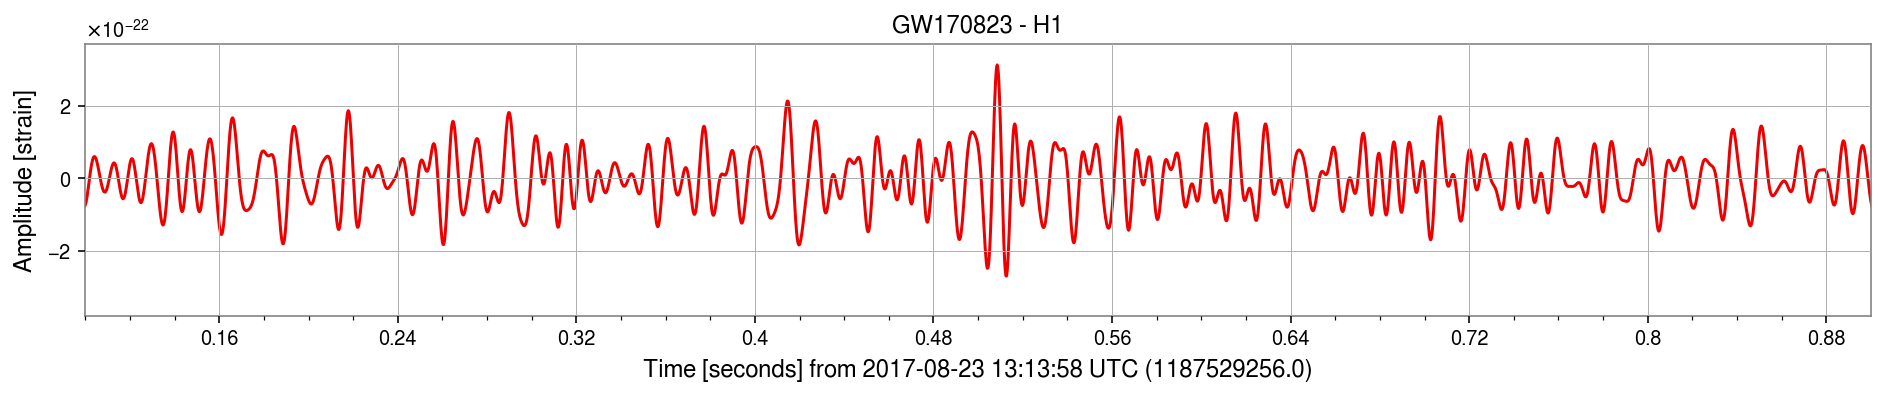

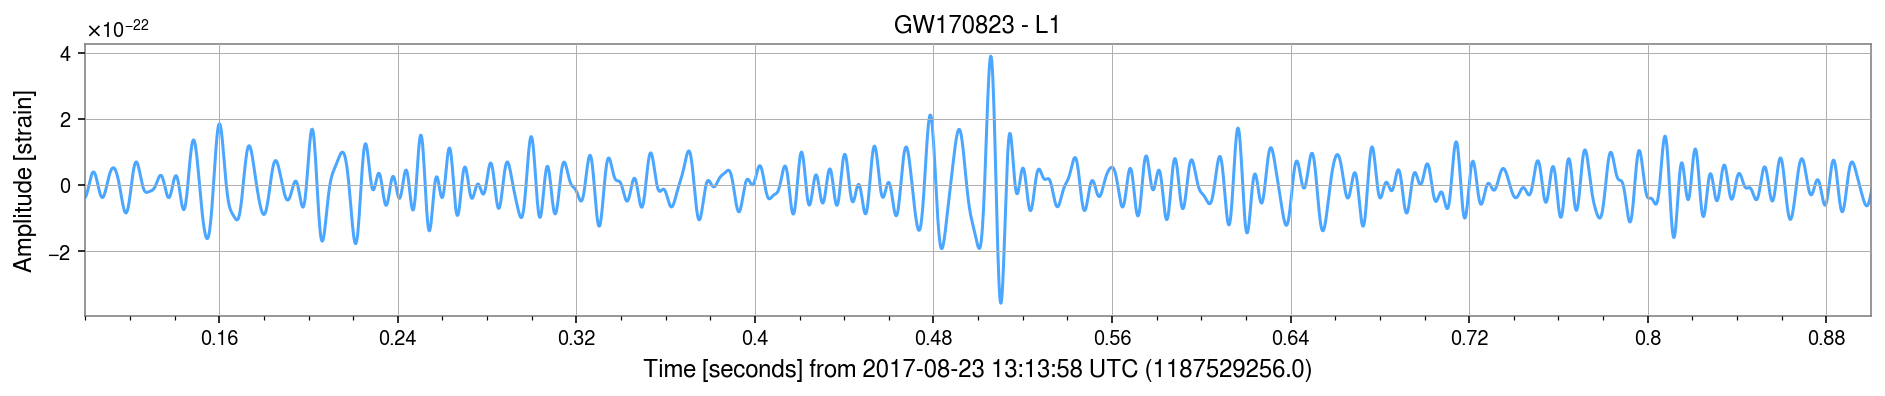

In [357]:
for i in [25,26]:
    s1 = clean_it_up(i, full_event_list, 56, 160)
    L,R = plot_strain(i, full_event_list, s1, -0.1, 0.9)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

In [358]:
#NB. we are ignoring [27], GW170823 - V1

#### ✓ GW190521 H1, L1 & V1

INTERVAL IS:  1.37
INTERVAL IS:  1.37


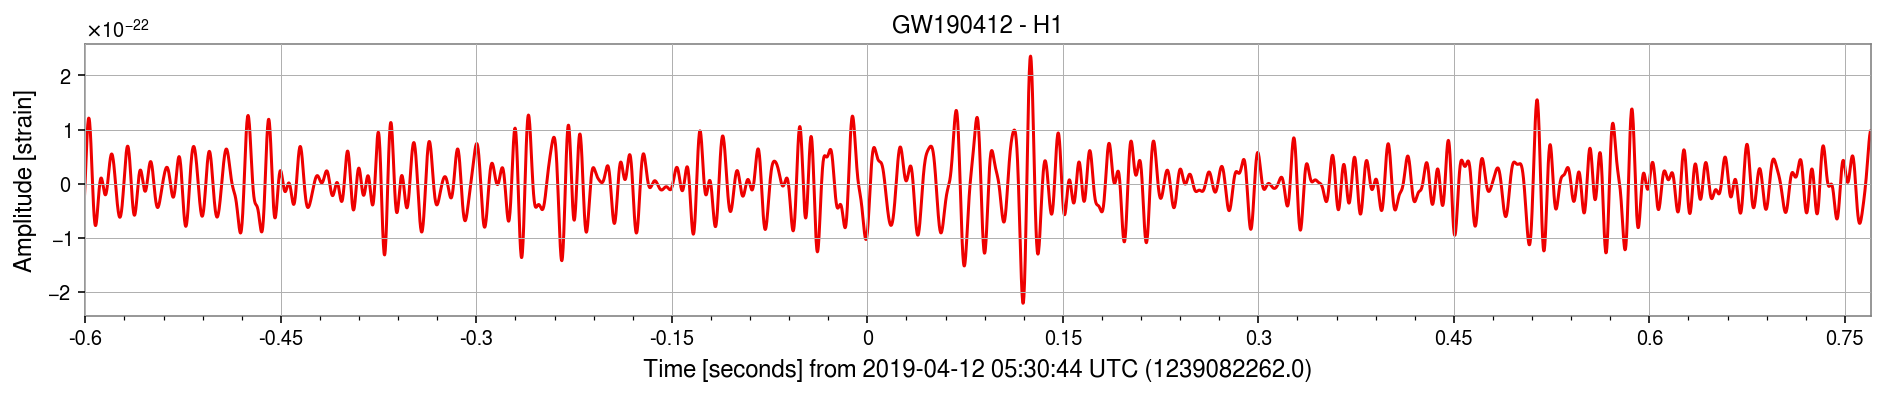

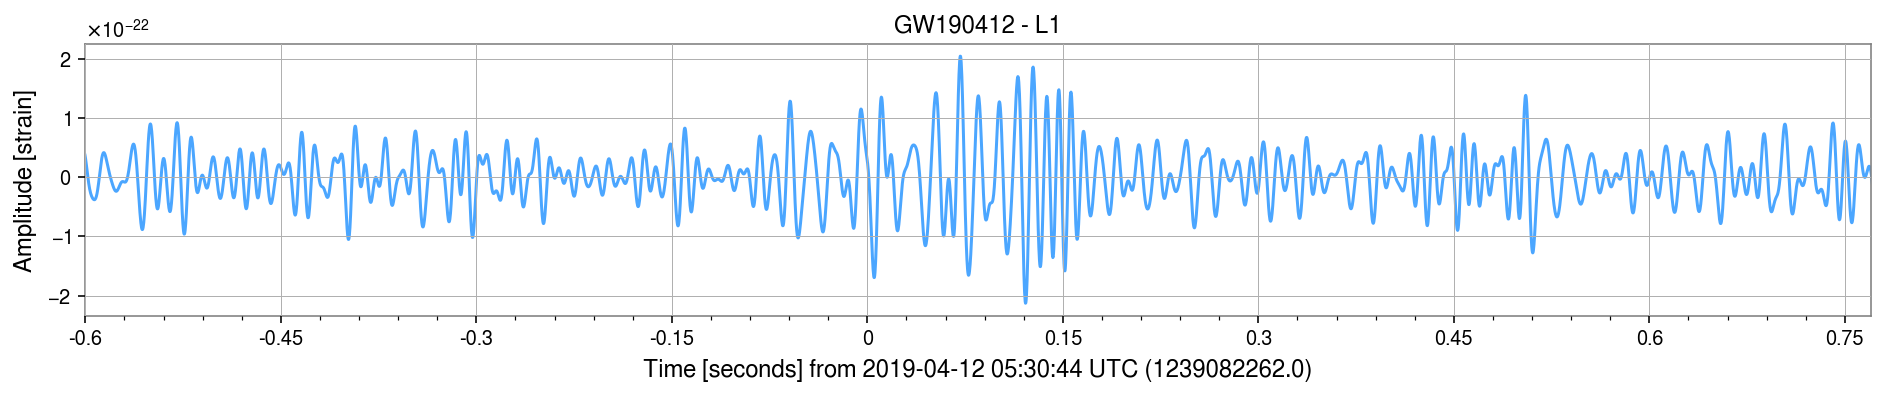

In [359]:
for i in [28,29]:
    s1 = clean_it_up(i, full_event_list, 50, 130)
    L,R = plot_strain(i, full_event_list, s1, 0.6, 0.77)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

#### ✓ GW190814 H1, L1 & V1

INTERVAL IS:  0.49999999999999994
INTERVAL IS:  0.49999999999999994


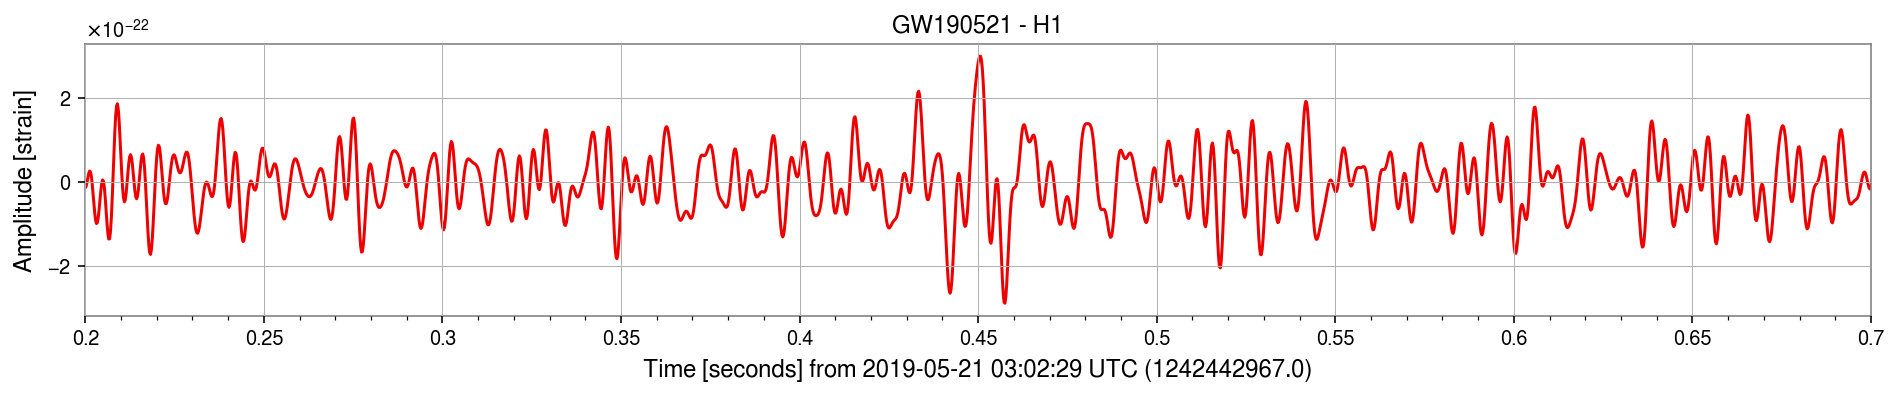

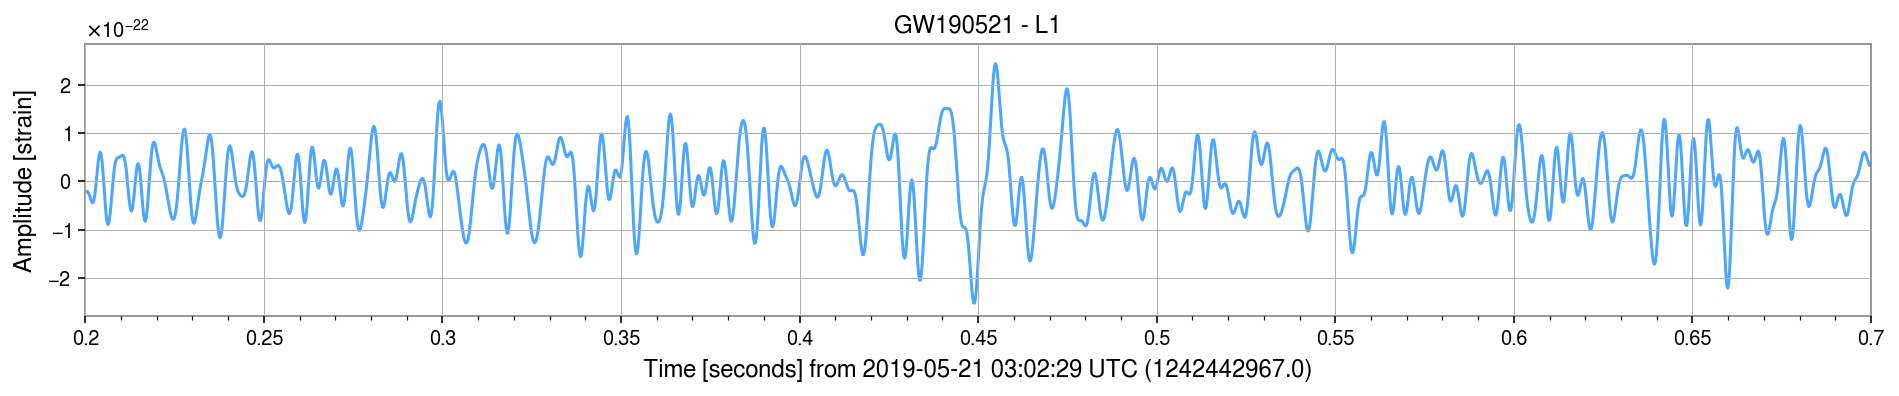

In [360]:
for i in [31,32]:
    s1 = clean_it_up(i, full_event_list, 56, 280)
    L,R = plot_strain(i, full_event_list, s1, -0.2, 0.7)

    the_interesting_data.append([s1, L, R, full_event_list[i][1], full_event_list[i][3]])

# TimeSeries --> Joy division style

To convert the TimeSeries data into joyplots, we need to:
- Select a filtered strain data
- apply a crop to the section of interest
- save the cropped & filtered strain data (always the same # of points)
- save all of them to a dataframe

The relevant strain data is in:  
- TimeSeries.value (array of strains)
- time center of series: `ts.t0+ts.dt*len(ts.value)/2` (if we call `ts` our filtered time series)


# Preparing data to Plot

### Sub-sampling

Not all data has the same number of points (since some of the interesting signals are longer in time).  To plot all the data on the same X-axis, we are going to require all signals to have the same number of points.  We will chose about 1200, which is the lowest number of points in one of the events.  For the ones with higher number of points (up to ~5000) we will downsample the graphs.

https://stackoverflow.com/questions/53307107/how-do-i-downsample-a-1d-numpy-array


In [361]:
from scipy import signal

In [362]:
down_data = the_interesting_data # rename so as to not overwrite
N_max = 1500 # max # of points to plot curve (based on time-series with least # of points)

a_sec = int(len(the_interesting_data[0][0].value)/32)
middle = int(len(the_interesting_data[0][0].value)/2)

In [363]:
# downsample data in-place for the list
for n, x in enumerate(down_data):
    
    # we need to slightly shift the cuttoff values we 
    # identified, because the plot function for Timeseries objects
    # and the plot function for matplotlib are slightly shifted
    # compared to each other
    start_e = int(middle - a_sec*(1.055+x[1]))
    end_e = int(middle + a_sec*(x[2]-1.05))
    
    interesting = x[0][start_e:end_e]
    down_interesting = signal.resample(interesting, N_max)
    down_data[n][0] = down_interesting

## All time-series now have the same # of points

In [364]:
final_data = {}

for x in down_data:
    name = "{}-{}".format(x[3],x[4])
    final_data[name] = x[0] # <- the cropped & down-sampled time series


In [365]:
df = pd.DataFrame(final_data)

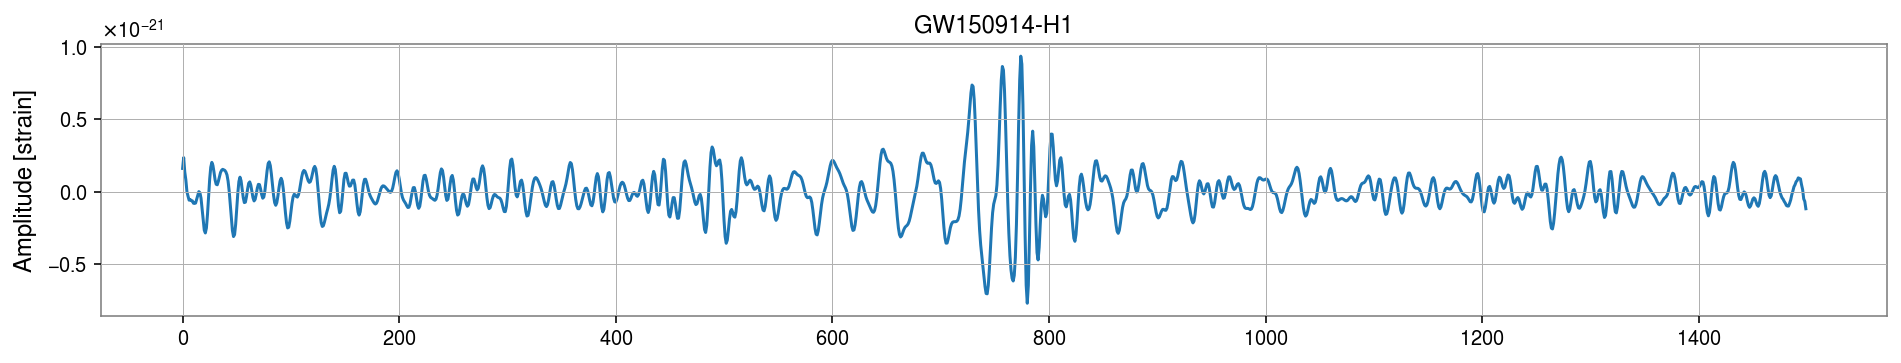

In [378]:
%matplotlib inline
plot_event(df, "GW150914-H1")

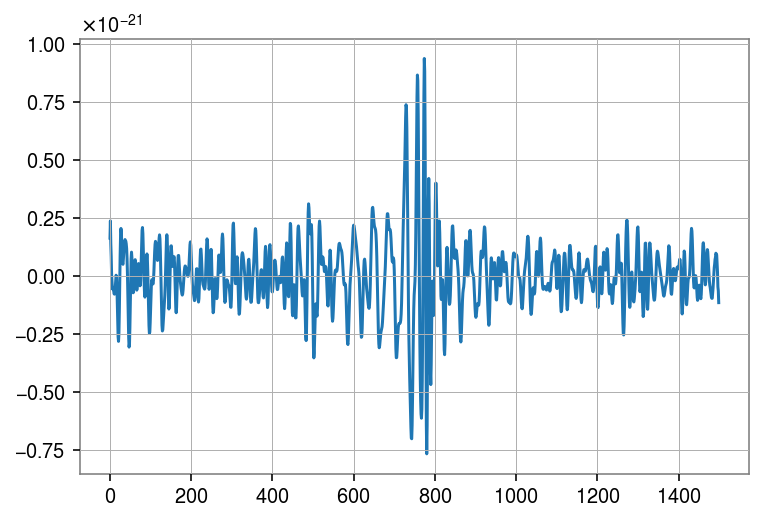

In [367]:
%matplotlib inline
plt.plot(df["GW150914-H1"])

## We will normalize the Virgo data so it's not too "tall"

In [368]:
tall_ones = ["GW170729-V1", "GW170809-V1", "GW170814-V1", "GW170817-V1", "GW170818-V1"]
for x in tall_ones:
    maxi = df[x].max()
    # the 6e-22 is chosen as one of the larger values in the normal data 
    down_factor = (6e-22/maxi)
    df[x] = df[x].apply(lambda x: x * down_factor)

In [369]:
nr_of_points = df.shape[0]

## Plot Parameters

In [370]:

# Plot Size
plot_width = 16
plot_height = 30

# Convolution
gaussian_stdev = 0.2 # -8 # approx the decay length of the gaussian
gaussian_height = 0.1
pre_collision_boost = 0.04 # 0.05 # 0.2 undoes the effect of the gaussian on the left side
# define data and x-axis
X = np.linspace(-1, 1, nr_of_points) 
Ga = gaussian_height * np.exp(-(X/gaussian_stdev)**2) # a gaussian

# start decreasing at two sigma
flat_boost_stop = int((1-2.2*gaussian_stdev)*len(Ga)/2)
# stop at one sigma
decay_boost_stop = int((1-gaussian_stdev)*len(Ga)/2)

flat_boost = np.zeros(nr_of_points)
decay_boost = np.zeros(nr_of_points)

for ind, x in enumerate(flat_boost):
    if ind <= flat_boost_stop:
        flat_boost[ind] = pre_collision_boost
for ind, x in enumerate(decay_boost):
    if (ind > flat_boost_stop) and (ind <= decay_boost_stop):
        decay_boost[ind] = pre_collision_boost - Ga[ind] 
        # pre_collision_boost/(ind-flat_boost_stop)**(0.3)
        #  decay_boost[ind] = pre_collision_boost*(1-(ind-flat_boost_stop)/(0.3*decay_boost_stop))
        
# Dataset Parameters
nr_of_curves = df.shape[1]
nr_of_points = df.shape[0] # in each curve

# Drawing Parameters
lw_initial = 1.5 # initial line width
ics_factor = 0.2 # intercurve separation factor

# Hacks
last_y = [0]# initial value


G = Ga + flat_boost + decay_boost

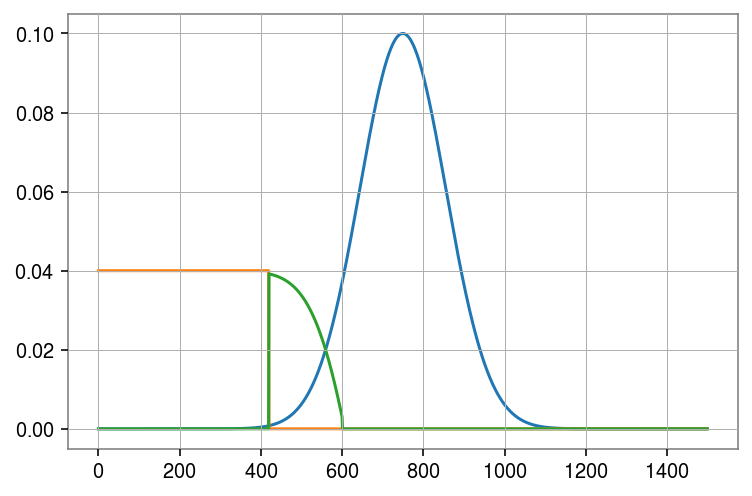

In [371]:
%matplotlib inline
plt.plot(Ga)
plt.plot(flat_boost)
plt.plot(decay_boost)


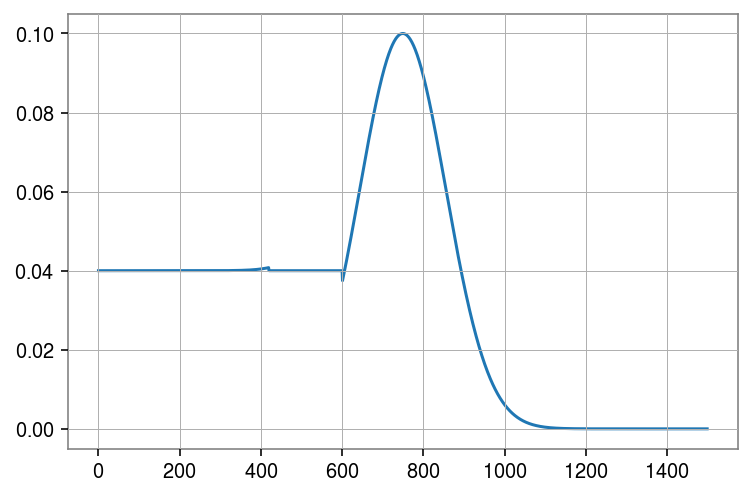

In [372]:
plt.plot(G)

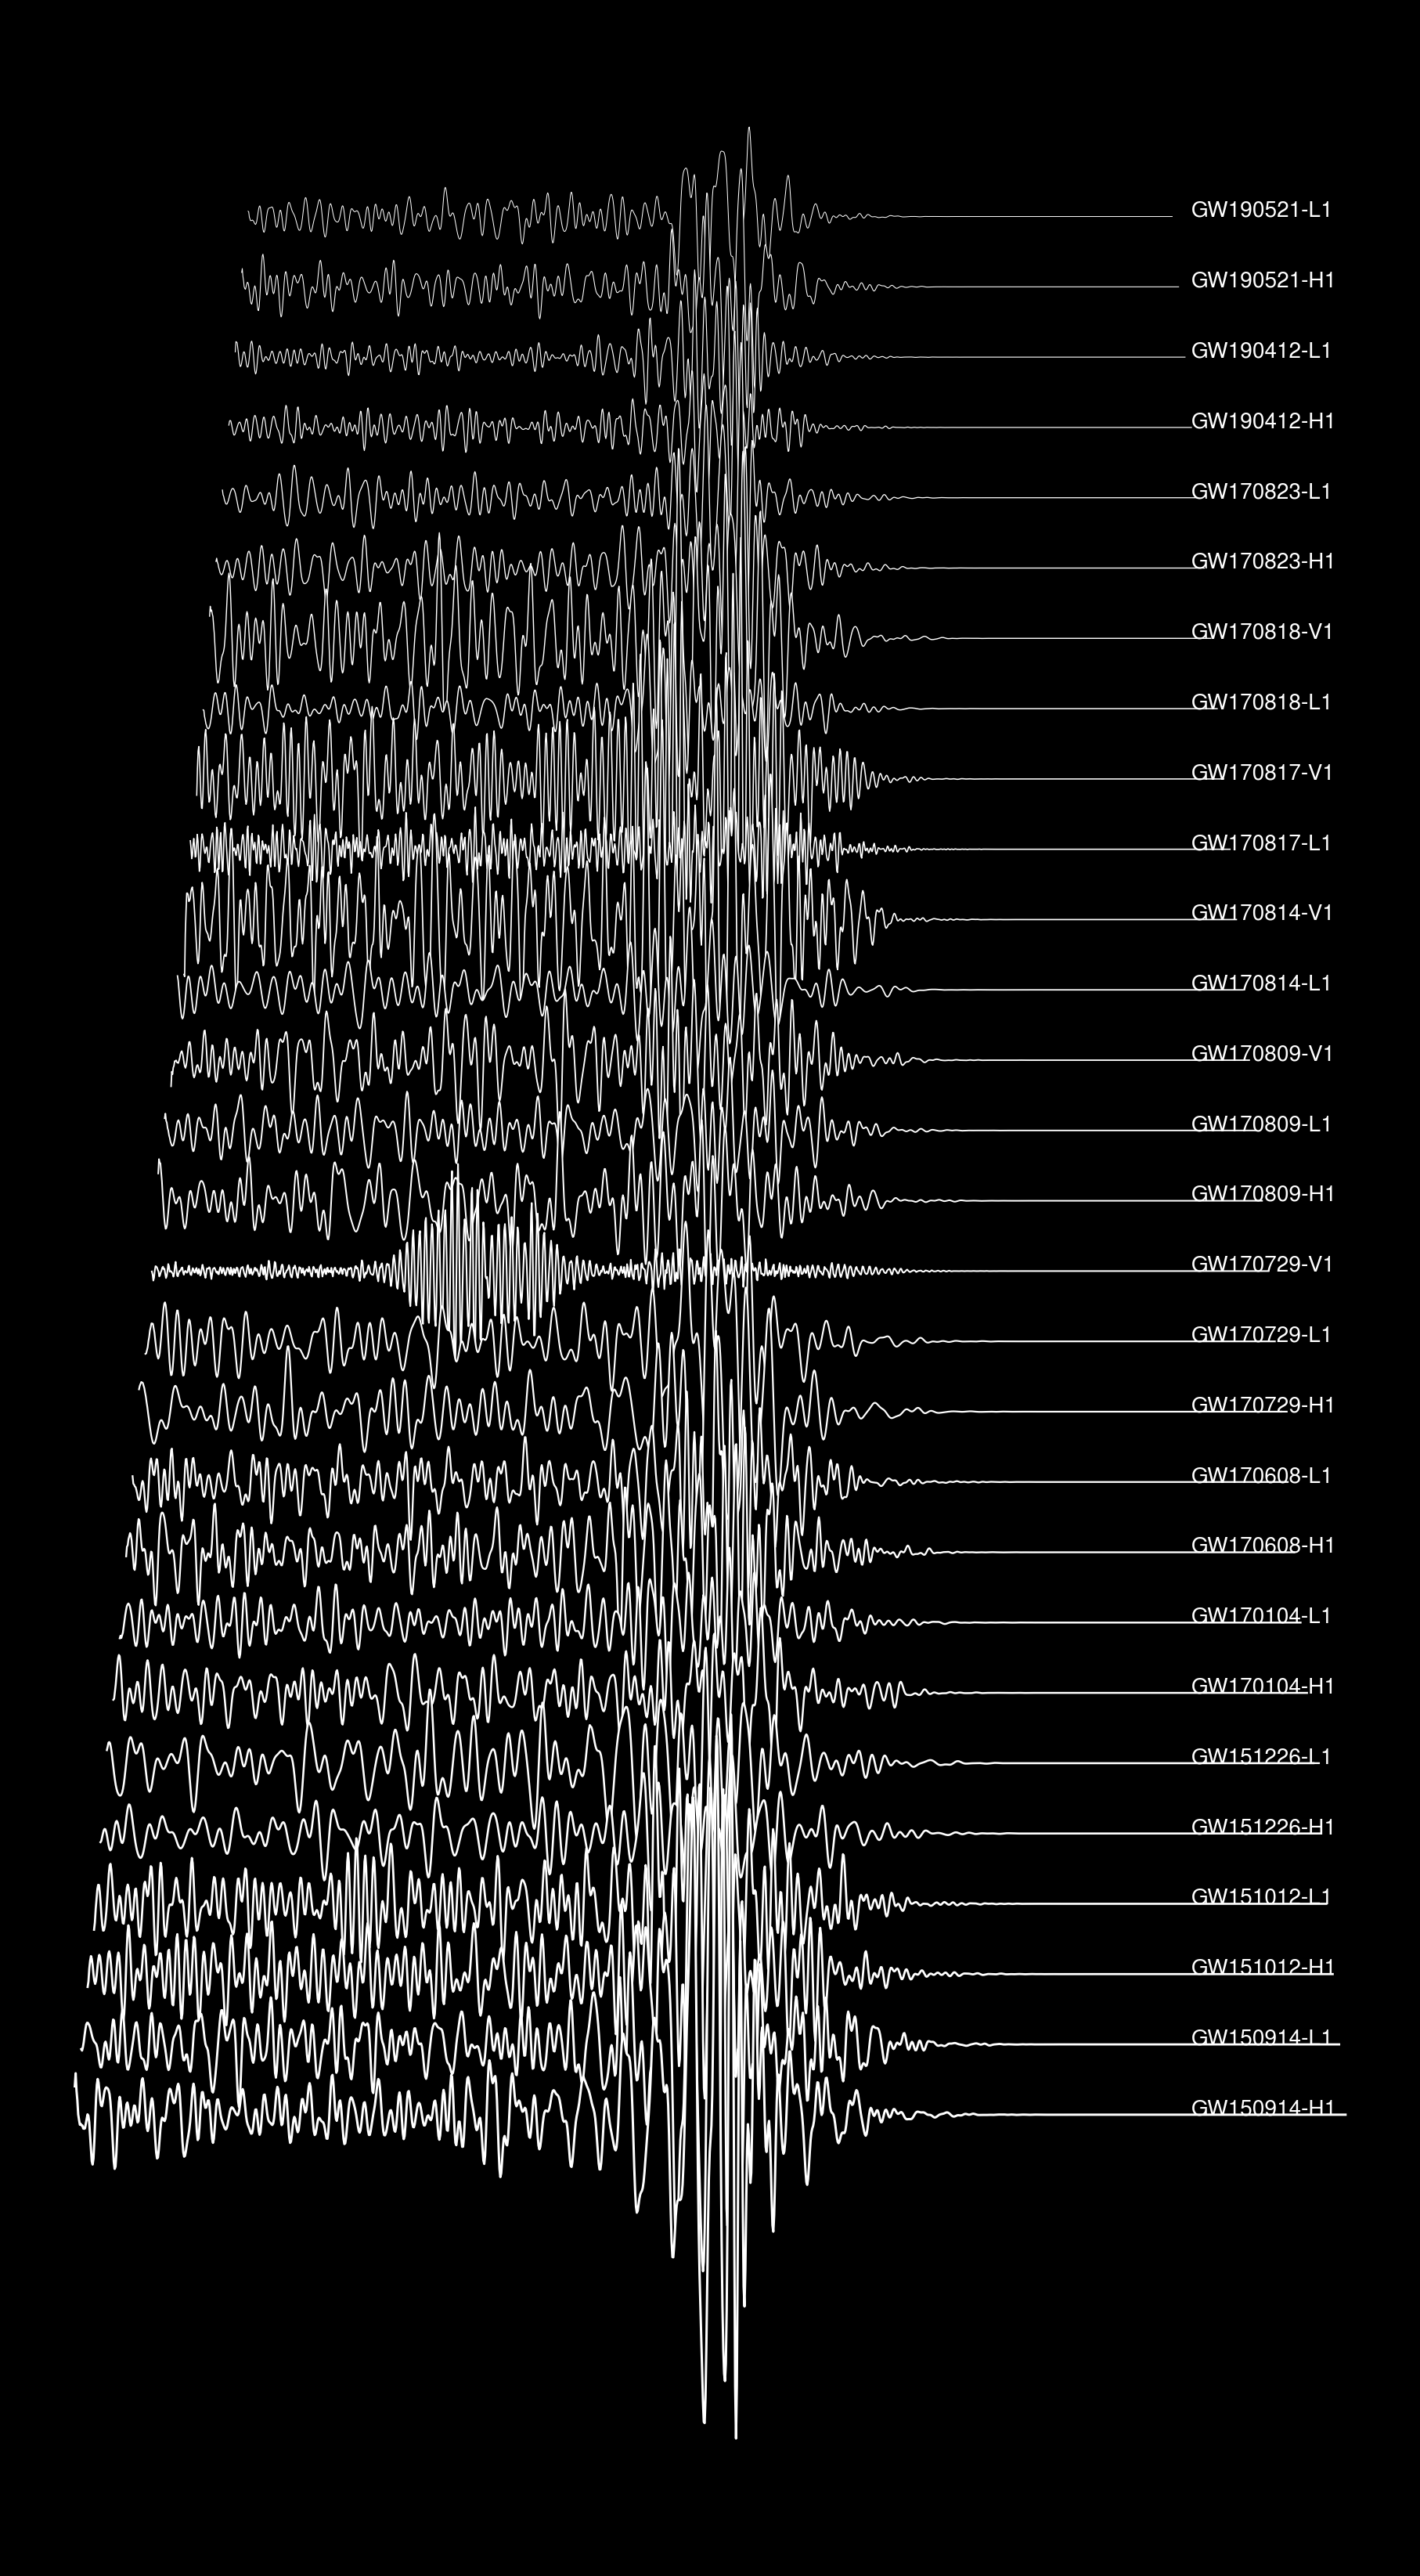

In [373]:
# Create new Figure with black background
fig = plt.figure(figsize=(plot_width, plot_height), facecolor=(0,0,0,1))
ax = plt.subplot(111, frameon=False)

# remove grid
ax.set_xticks([])
ax.set_yticks([])

for ind, event_n in enumerate(df.columns,1):
    
    if ind > 28: # <- skip loop over this number (used to draw only subset)
        continue
    
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - ind / 100.
    # Same for linewidth (thicker strokes on bottom)
    mylw = lw_initial - 1*ind / (nr_of_curves)
    #print(mylw, ind)
    
    inter_curve_separation = ics_factor*8e-23*ind
    y = inter_curve_separation + G*df[event_n]
    # y = inter_curve_separation + df[event_n]
    
    # print((max(y)))

    if ind == 1:
        # something's up with the first curve.
        # this is a hack to make the width work
        ax.plot(xscale * X, y, 
                color="w", 
                lw=lw_initial,
                zorder = nr_of_curves-ind)
    elif max(y) > 2e-21:
        # little hack to make plot more balanced
        # one plot is 60 times higher than all other ones
        # that number may not be the right choice !!!
        # needs more careful attention & possibly normalizing
        # all curves in the dataframe in advance
        y = inter_curve_separation + 1/60*G*df[event_n] 
        ax.plot(xscale * X, y, 
                color="w", 
                lw=mylw,
                zorder = nr_of_curves-ind)
    elif ind > 1: # and 'V1' in event_n:
        # for all other curves
        ax.plot(xscale * X, y, 
                color = "w",
                # color=(4*ind/nr_of_curves,0,1-3*ind/nr_of_curves,1)
                lw=mylw,
                zorder = nr_of_curves-ind)

    ax.text(0.75, np.mean(y), event_n, fontsize=14, color='w', zorder=nr_of_curves)
    # largest zorder in the front
    if ind > 28: # <- just to fill some of them as a test
        continue
    else:
        ax.fill_between(xscale * X, y, -6e-23, zorder = nr_of_curves-ind, facecolor=(0,0,0,1) )
    
plt.show()
fig.savefig('plot.png', dpi=300)

## Saving the data to CSV

In [515]:
normalized_data = df * 0.4*10e22

In [381]:
normalized_data.to_csv("normalized_ligo_data.csv")

In [388]:
20*np.ones(10)

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

In [521]:
def plot_event(dataframe, event_name, scale_factor=1, ramp_down_center=850, ramp_down_speed=20, nr_points=1500):
    '''
    plot two copies of the event
    - the standard one 
    - a scaled one with a gaussian filter applied
    :dataframe df: pandas dataframe with event time-series data
    :event_name str: event name with lab: format GW150914-H1
    :scale_factor float: vertical scaling (for graphs too big or small)
    :ramp_down_center int: point(out of 1500) where the down_ramp starts
    :gauss_std: standard deviation of the gaussian 
    '''
    fig, ax = plt.subplots(2, figsize=(16, 9), facecolor=(0,0,0,1), frameon=False)
    # fig.tight_layout(pad=1.0)

    # first graph. Data as is:
    ax[0].plot(dataframe[event_name], color='w')
    ax[0].plot(40*np.ones(nr_points), color='r')
    ax[0].plot(-40*np.ones(nr_points), color='r')
    
    # second graph. Filtered Data
    X = np.linspace(-1, 1, nr_points) 
    
    # ramp down
    ramp_down = np.exp(-ramp_down_speed*(X-ramp_down_center/nr_points+1/2)) # 1/(100*X)
    ramp_down = np.where(ramp_down > 1, 1, ramp_down)
    # ramp up
    ramp_up = 0.2 + 1/20*(X+2)**4
    ramp_up = np.where(ramp_up > 1, 1, ramp_up)
    
    data_n_cos = dataframe[event_name].copy()
    for ind, x in enumerate(data_n_cos):
        if ind < 380:
            data_n_cos[ind] += 10*np.cos(ind/10) # + data_n_cos[ind]
        else:
            continue
    
    ax[1].plot(scale_factor*ramp_up*ramp_down*dataframe[event_name], color='w')
    # ax[1].plot(scale_factor*ramp_down*ramp_up*data_n_cos, color='w')
    ax[1].plot(30*ramp_down, color='b')
    ax[1].plot(30*ramp_up, color='b')
    ax[1].plot(40*np.ones(nr_points), color='r')
    ax[1].plot(-40*np.ones(nr_points), color='r')
    # ax[1].plot(30*np.cos(100*X))
    
    # remove grid
    for i in [0,1]:
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].title.set_text(event_name)
        # ax[i].axis('off')
        ax[i].set_facecolor((0,0,0,1)) 
    

# Graphs, handcrafted with ❤

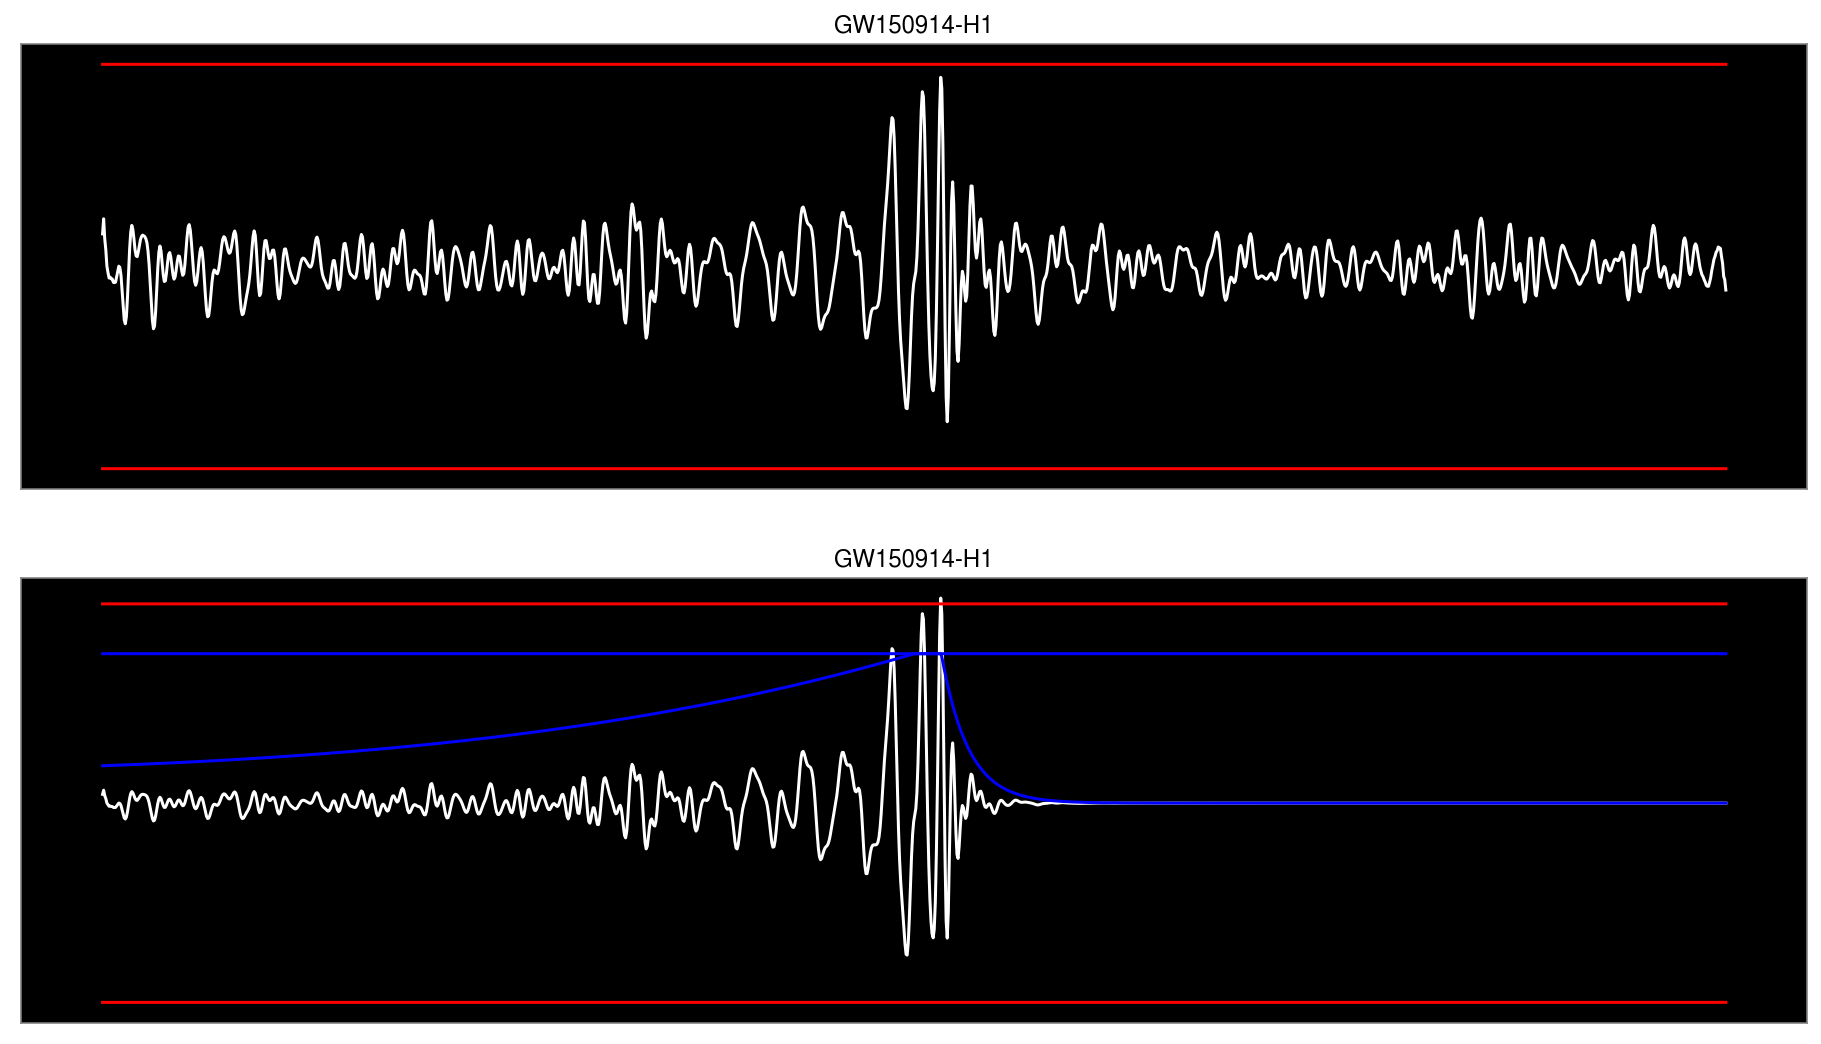

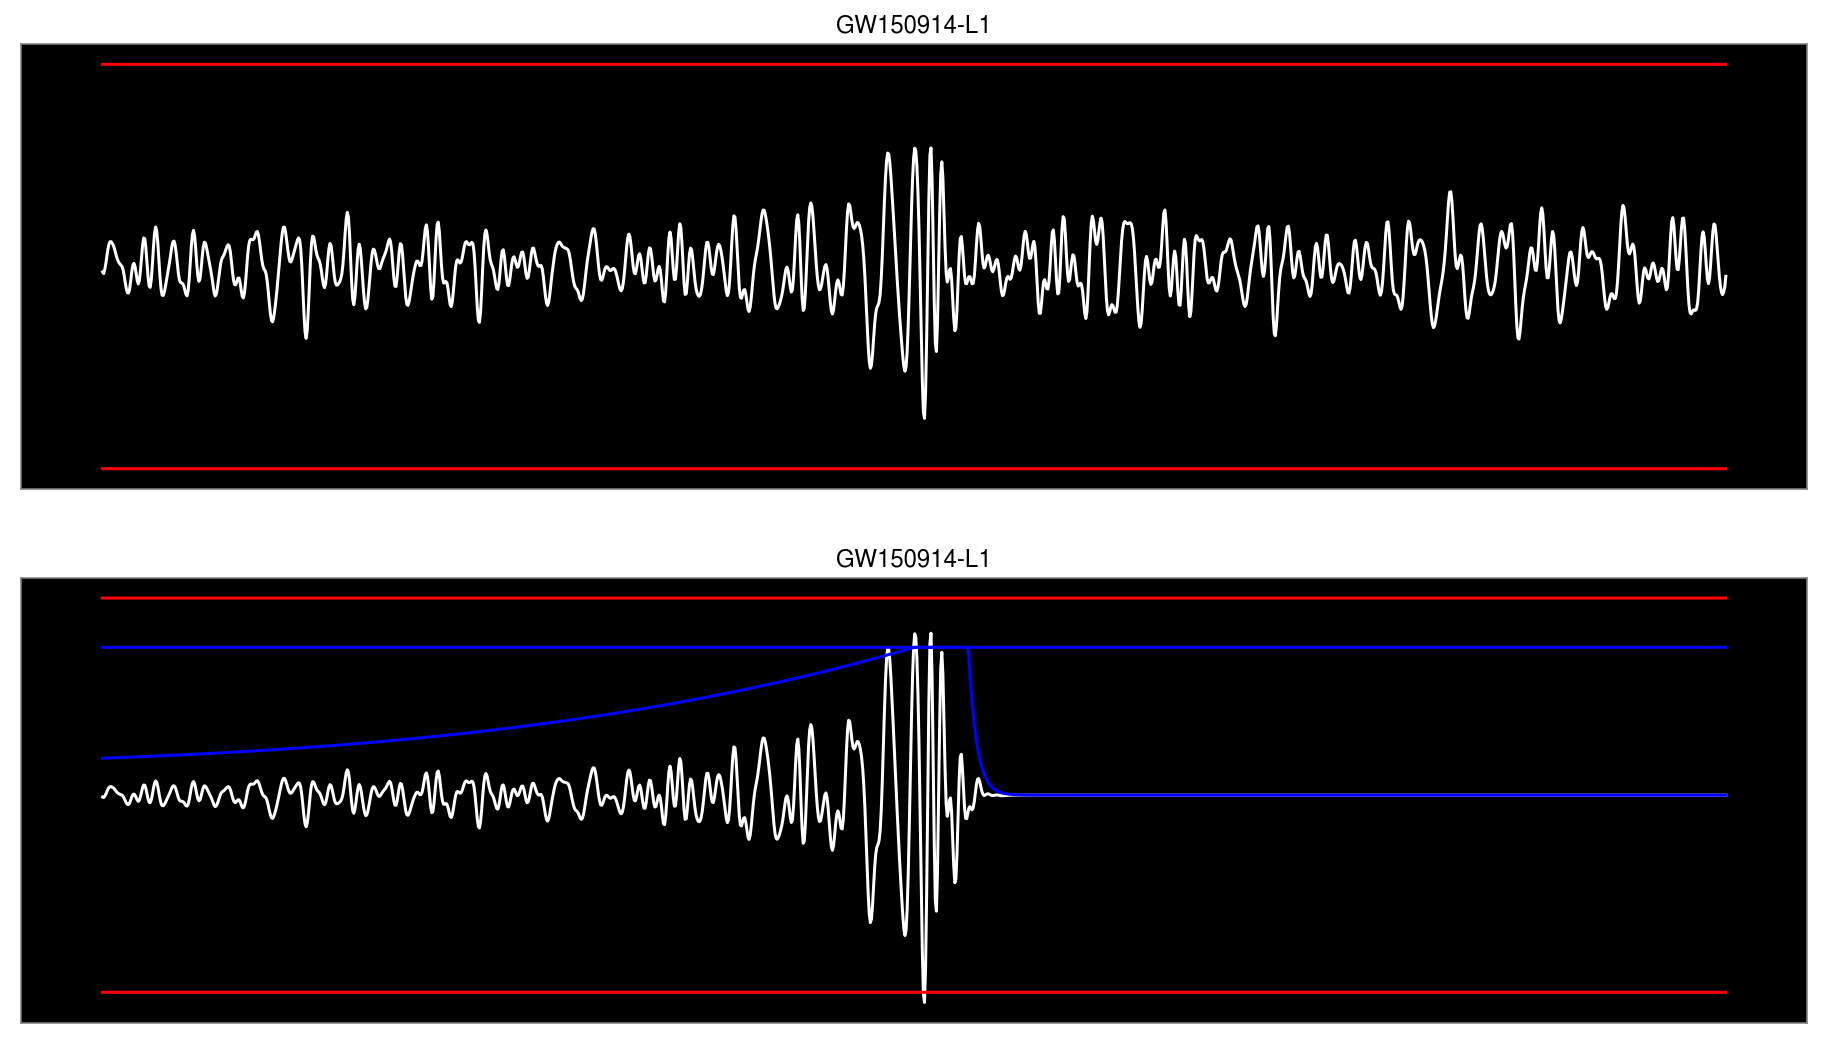

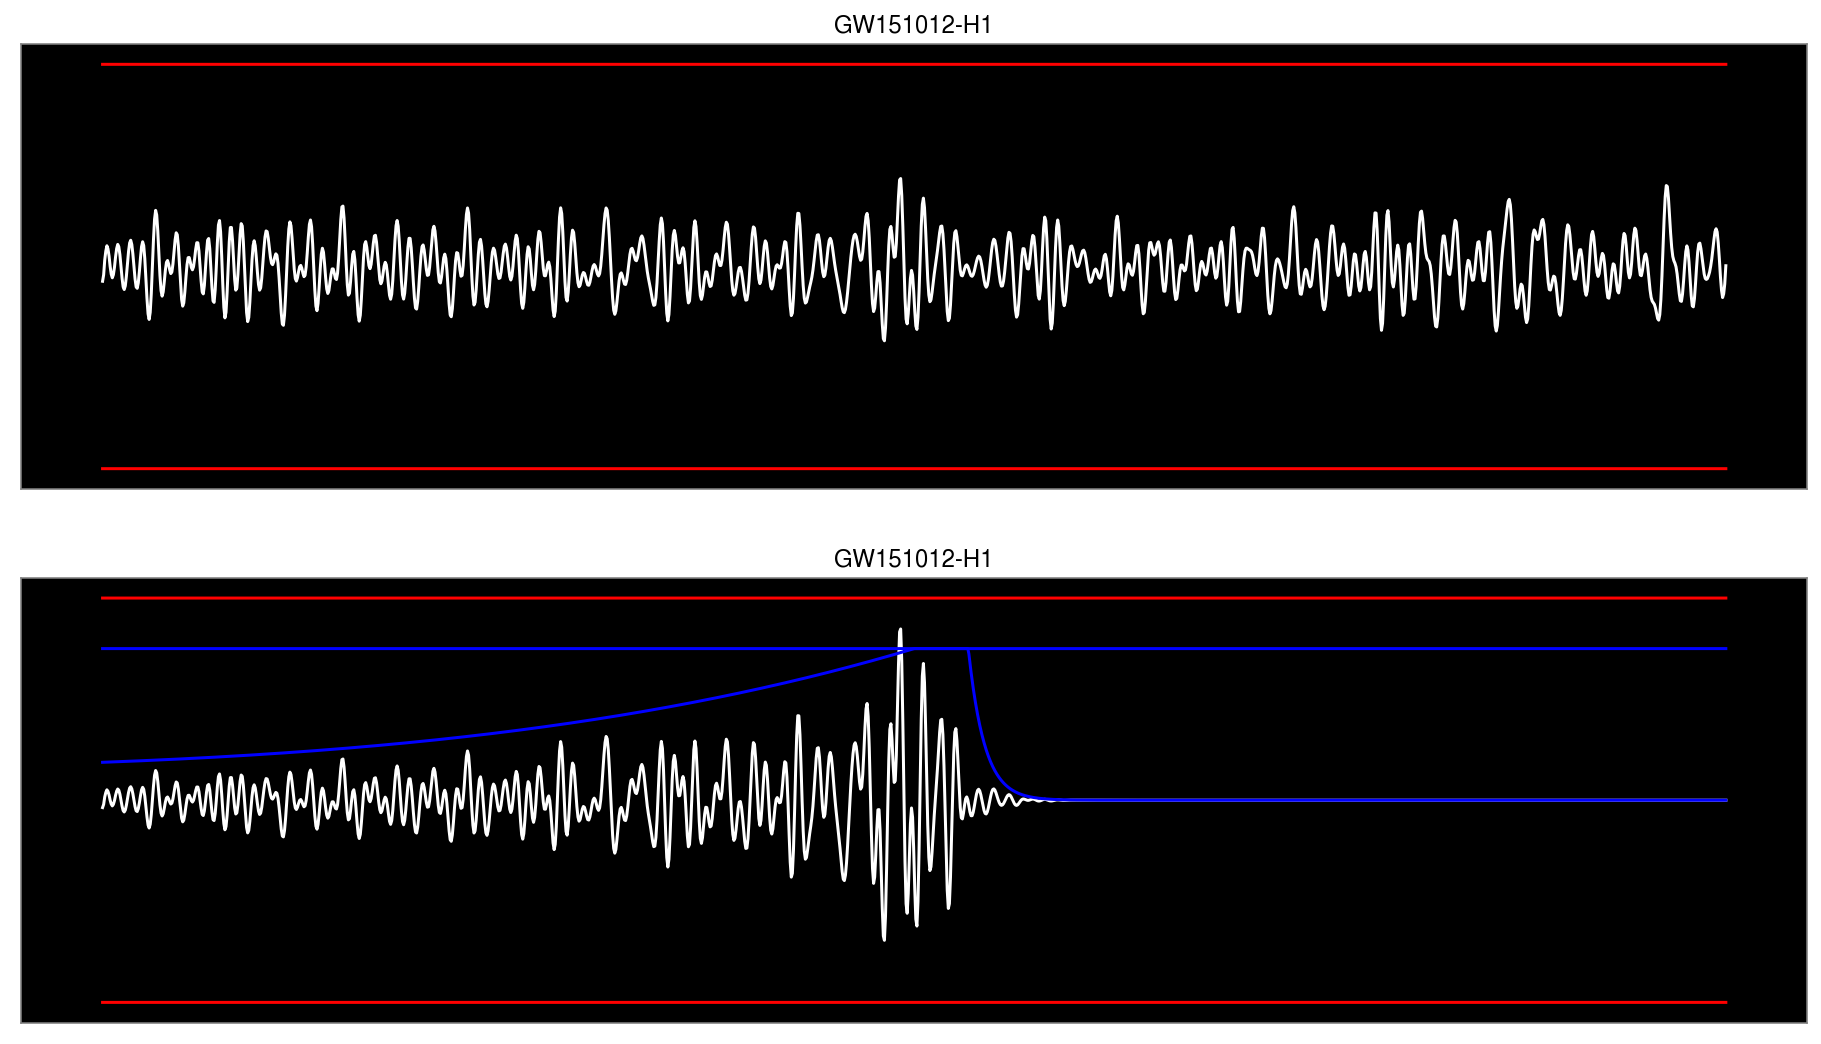

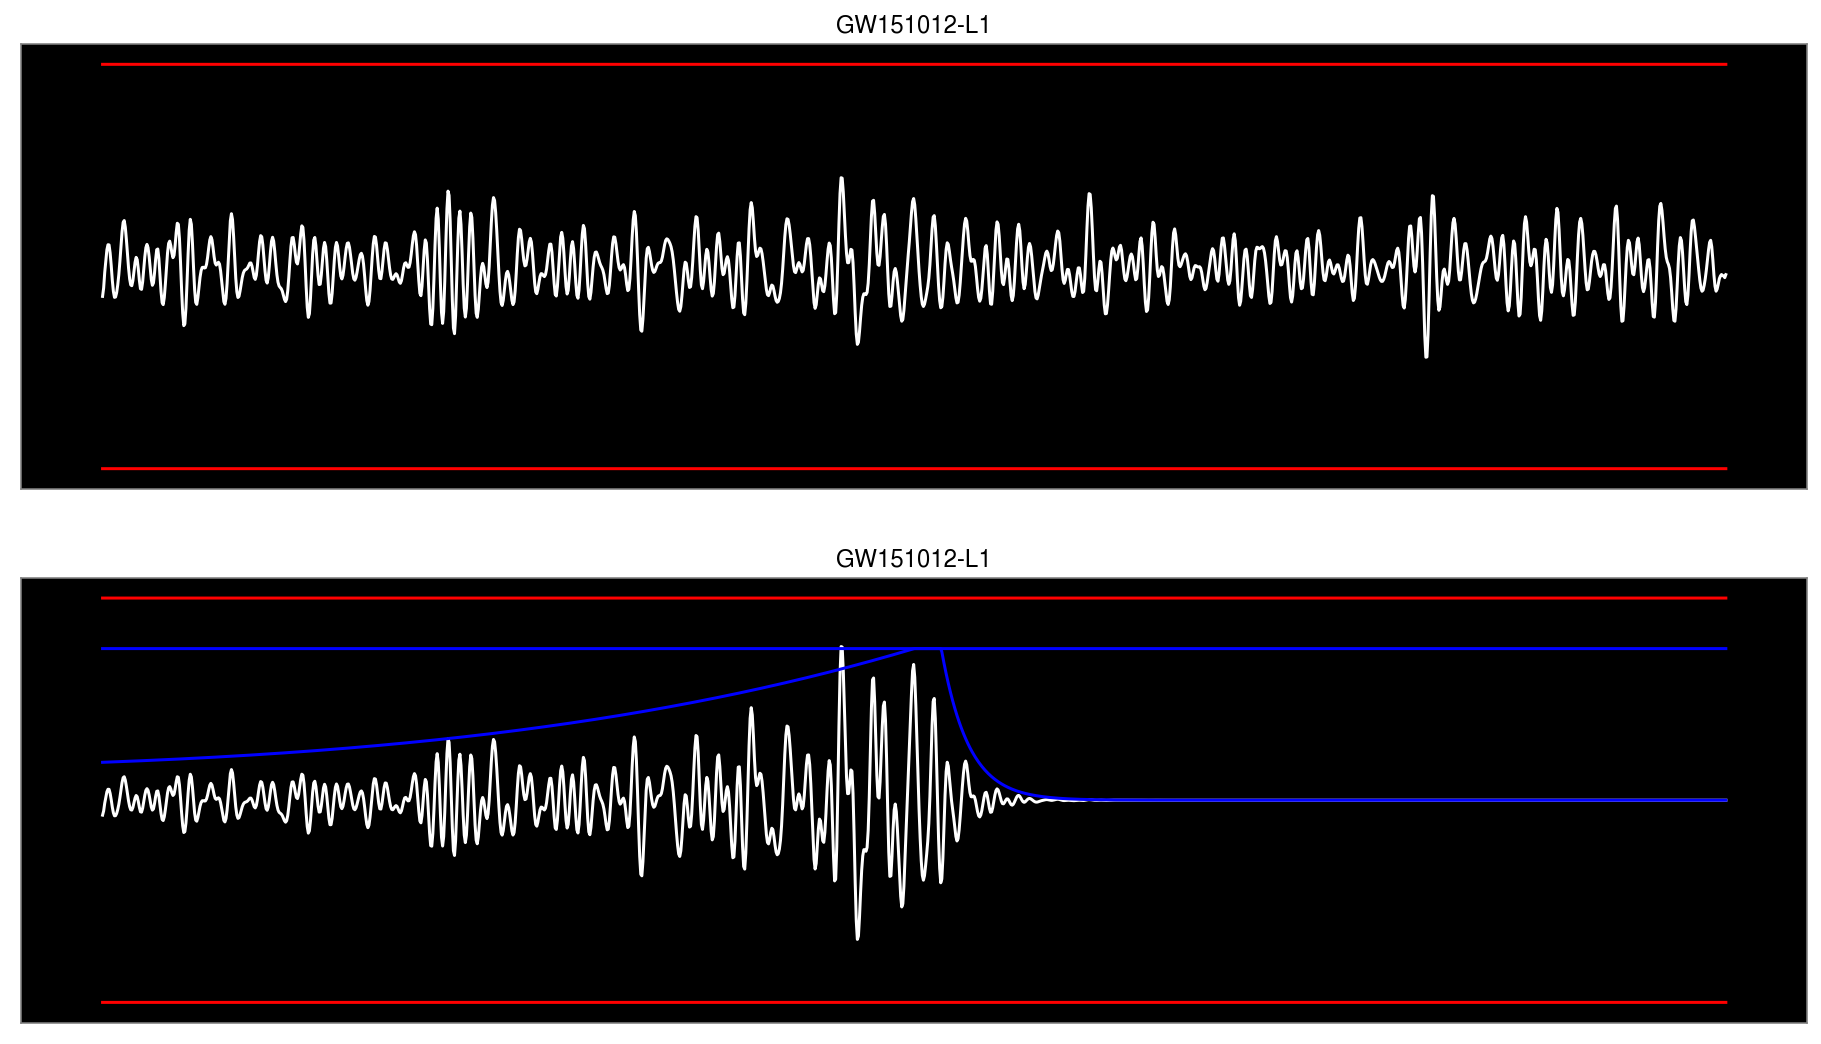

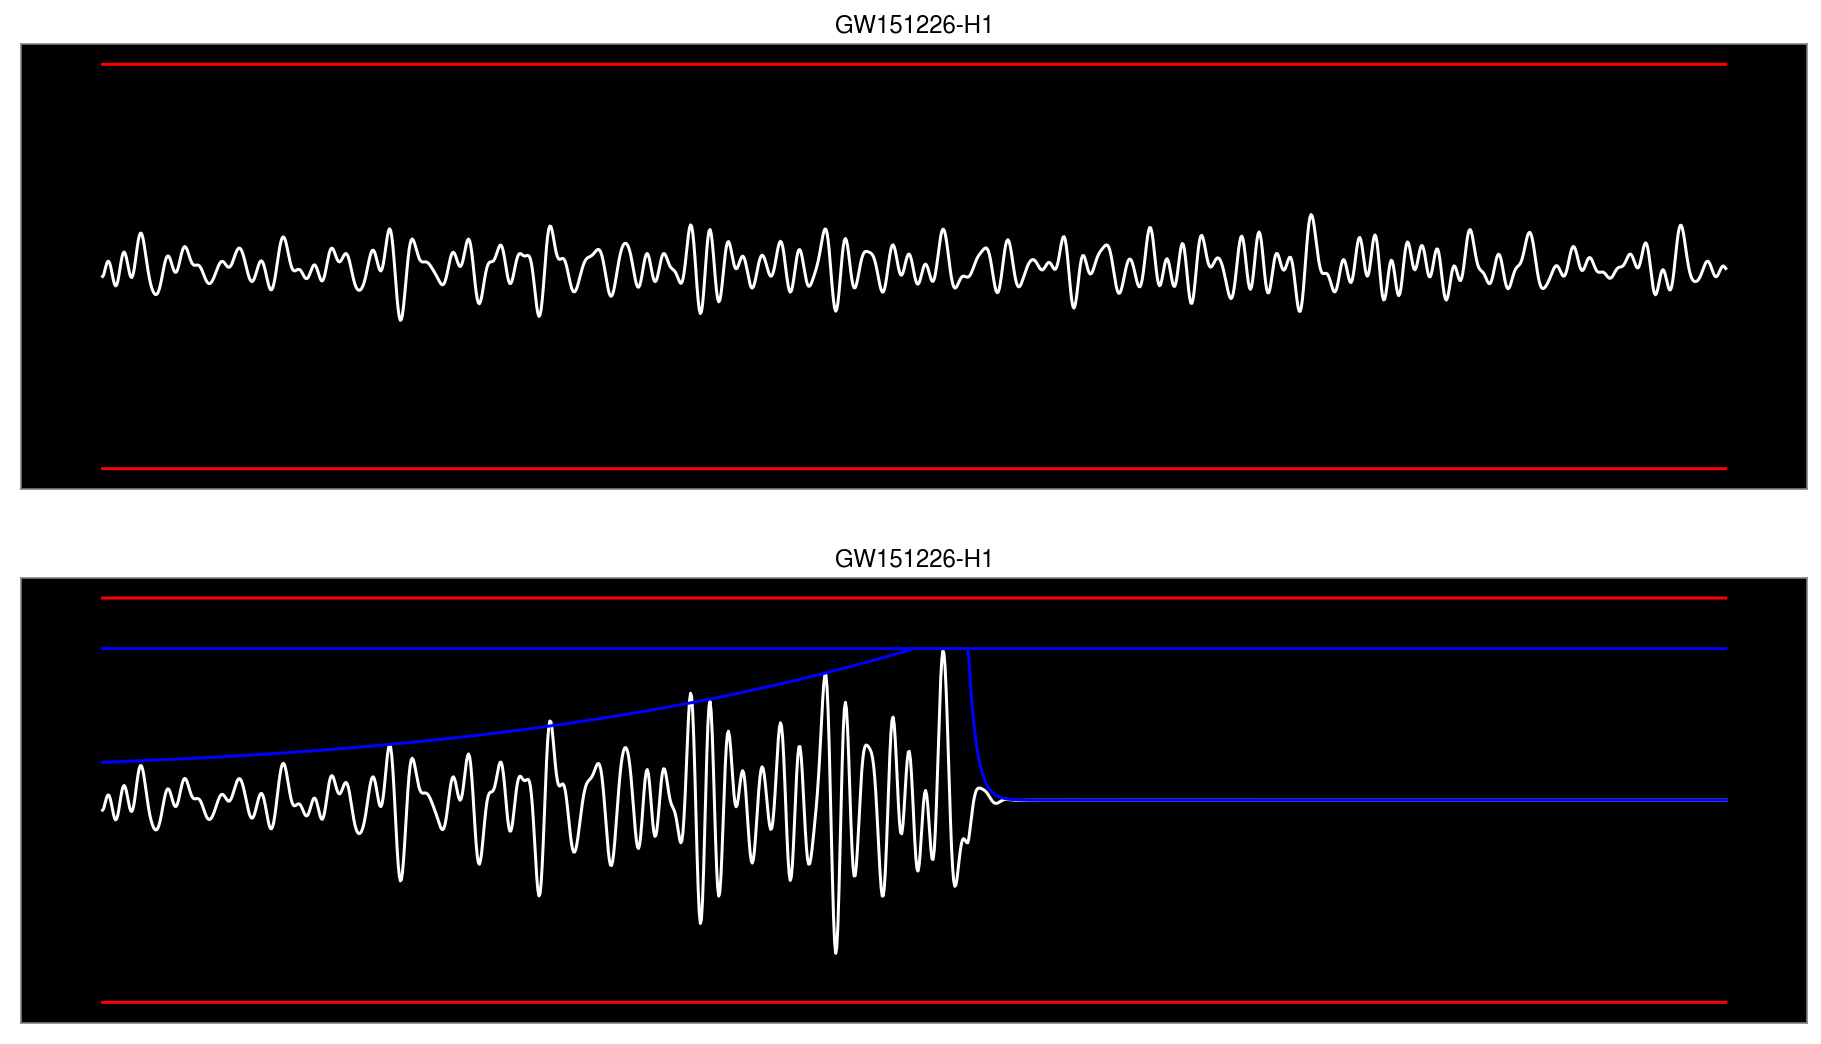

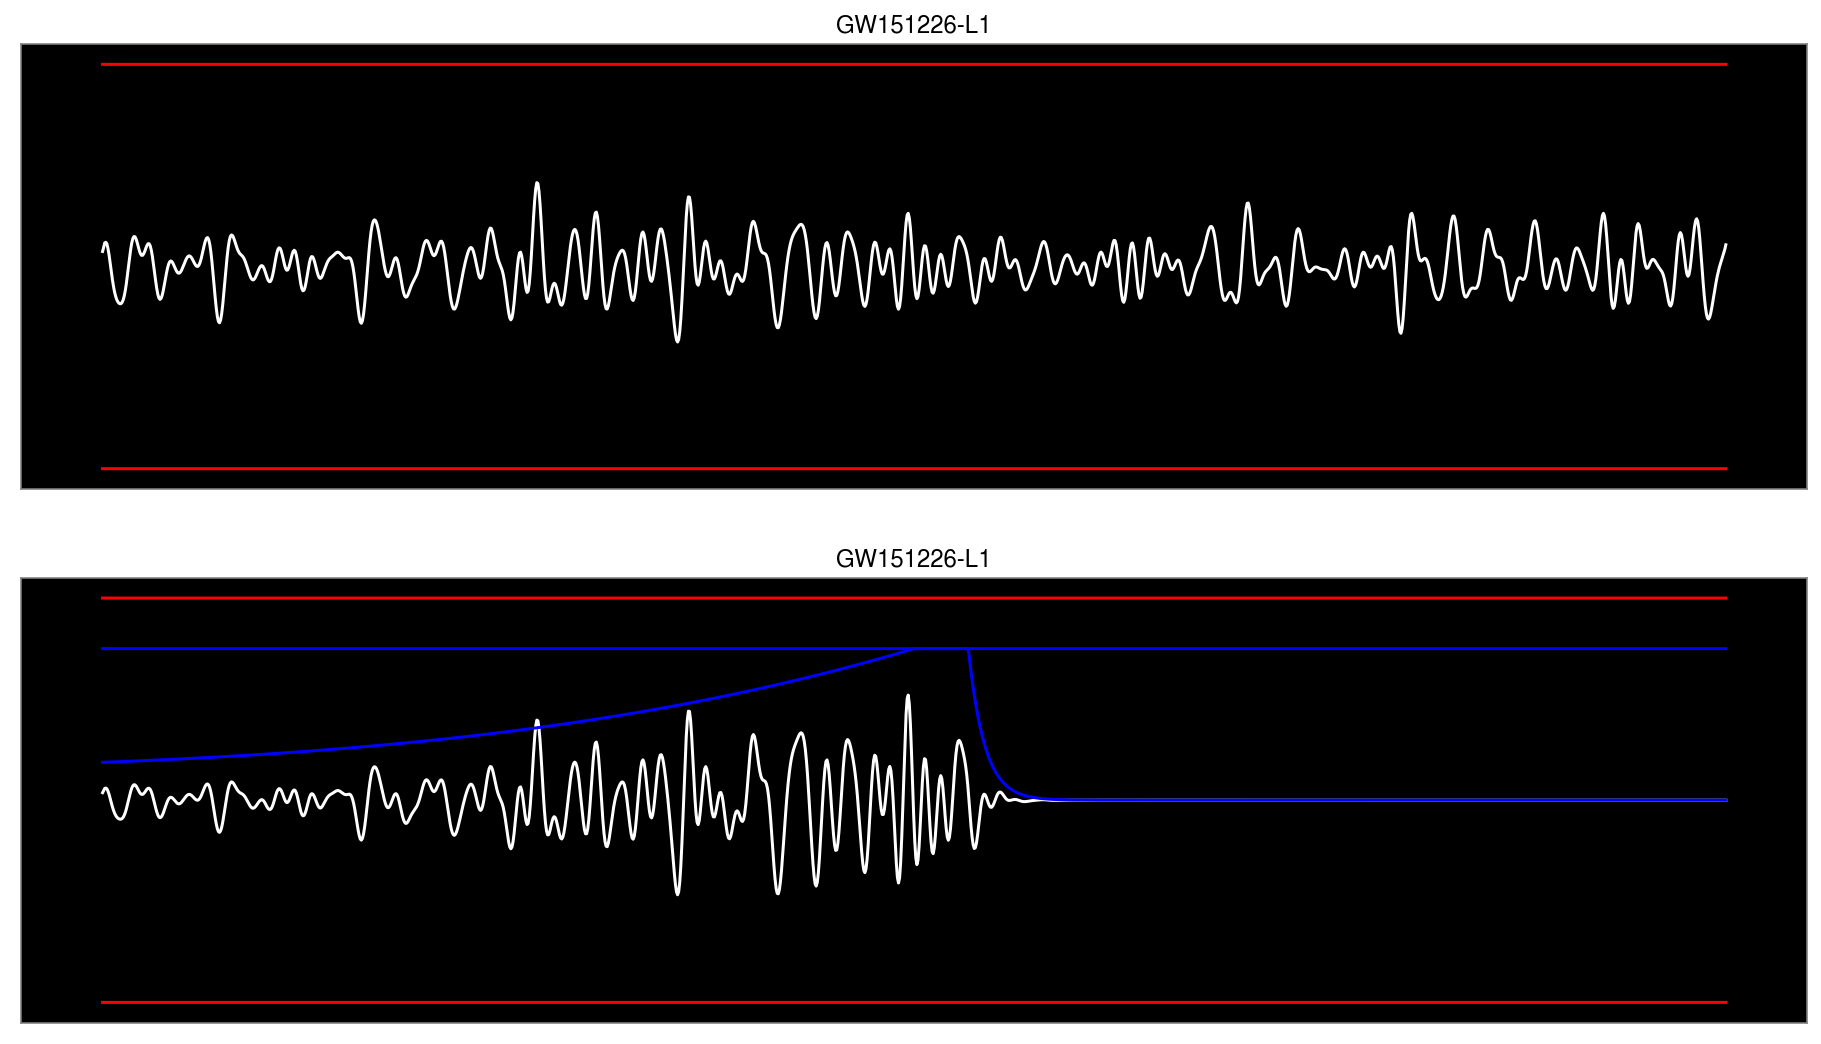

In [523]:
%matplotlib inline
params = [
    [1.1, 800, 30],
    [1.4, 850, 100],
    [2, 850, 50],
     [2, 800, 30],
    [4, 850, 100],
    [2, 850, 50],
    
]
for n, x in enumerate(normalized_data.columns[0:6]):
    plot_event(normalized_data, x, params[n][0], params[n][1], params[n][2])


## Ideas

for some versions of the t-shirts, keep 

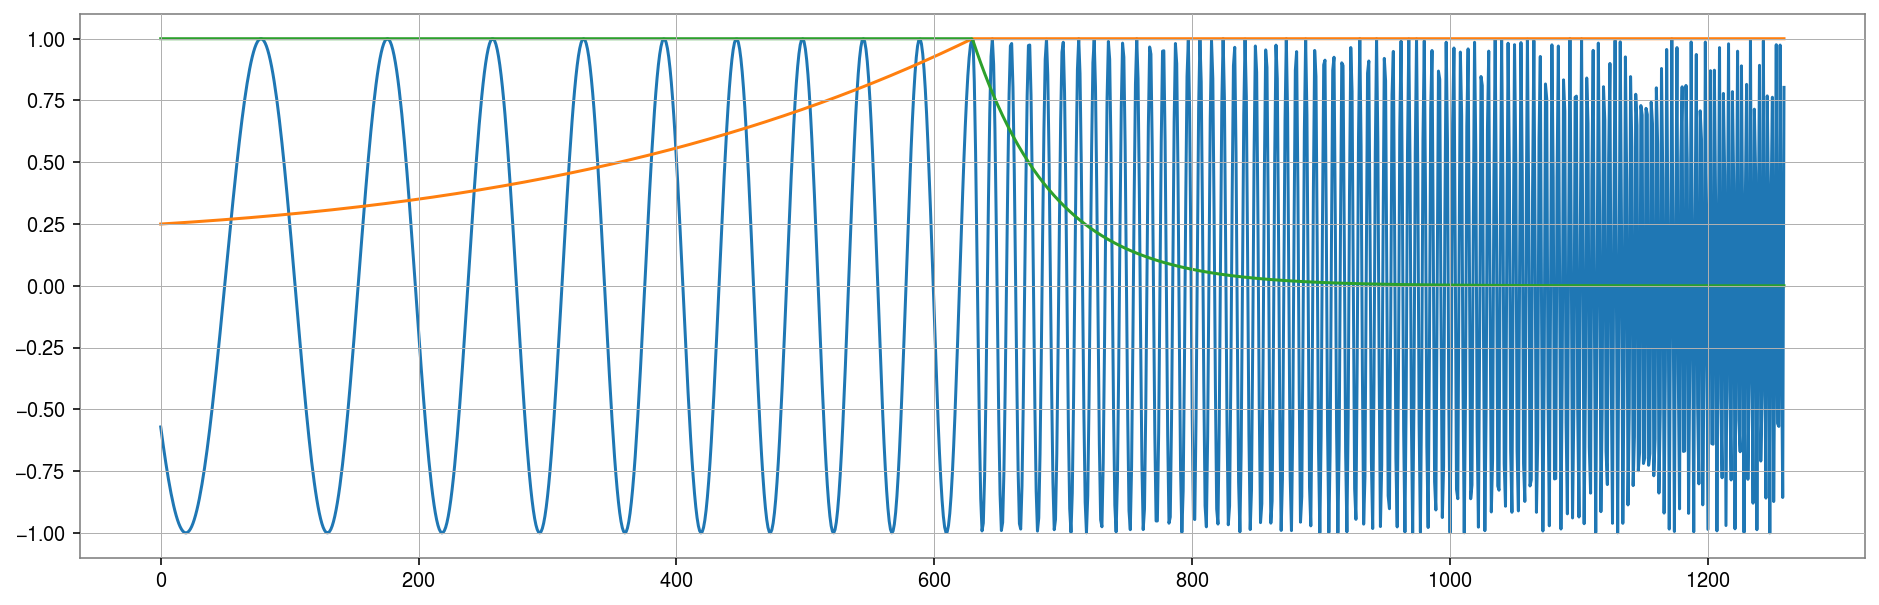

In [62]:
%matplotlib inline
N = nr_of_points

X = np.linspace(-1, 1, nr_of_points) 

# frequency boost for the second half
freq_boost = np.ones(N)
for ind, x in enumerate(freq_boost):
    if ind > N/2:
        freq_boost[ind] = 1+3*ind/N

# a cosine of increasing frequency
# start of cosine: 
soc = 2
T = np.cos(100*X*(np.exp(X/2))*freq_boost)

ramp_up = 0.2 + 1/20*(X+2)**4
ramp_up = np.where(ramp_up > 1, 1, ramp_up)


ramp_down = np.exp(-10*X) # 1/(100*X)
ramp_down = np.where(ramp_down < 0, 1, ramp_down)
ramp_down = np.where(ramp_down > 1, 1, ramp_down)

plot_width = 16
plot_height = 5

fig = plt.figure(figsize=(plot_width, plot_height))
plt.plot(T)
plt.plot(ramp_up)
plt.plot(ramp_down)

In [63]:
some_event = df["GW170104-H1"]/df["GW170104-H1"].max()

In [64]:
first_event = df.iloc[:,1]/df.iloc[:,1].max()


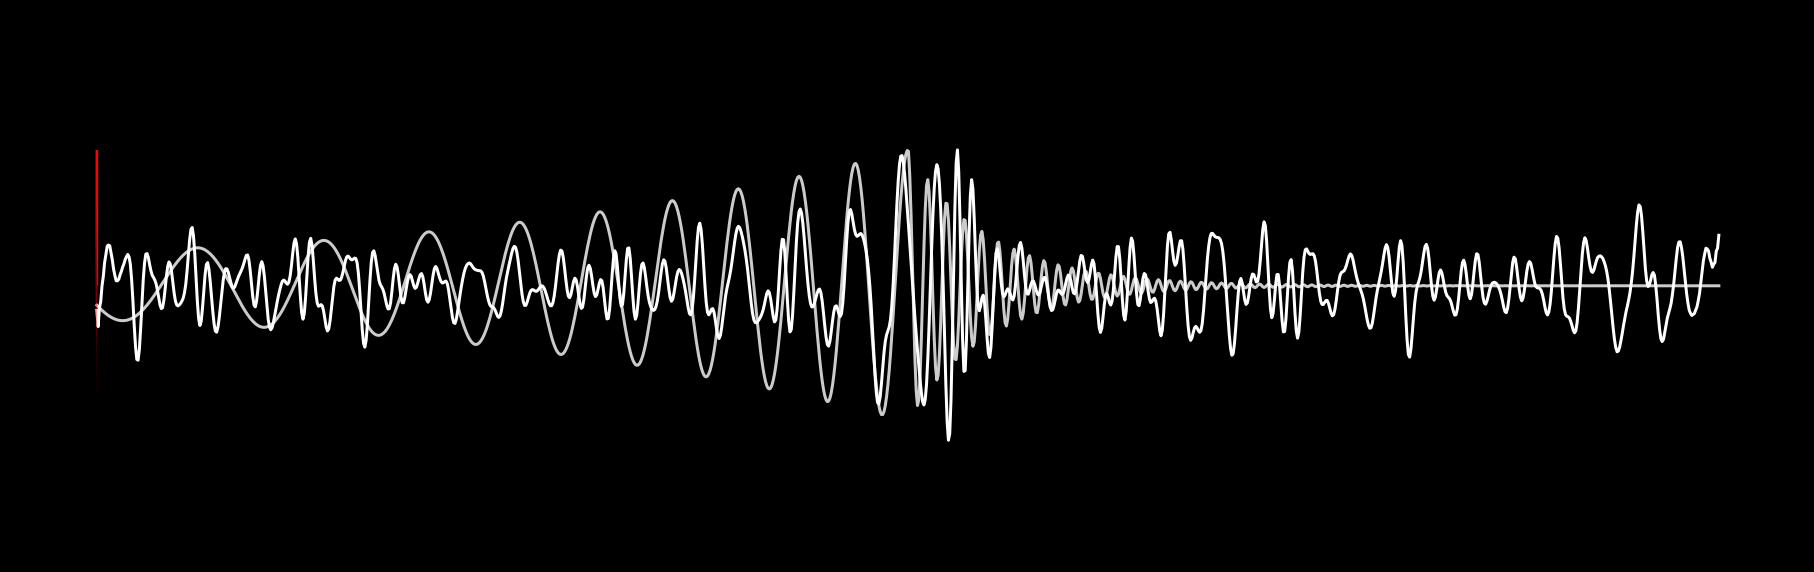

In [66]:
%matplotlib inline
plot_width = 16
plot_height = 5

fig = plt.figure(figsize=(plot_width, plot_height), facecolor=(0,0,0,1))
ax = plt.subplot(111, frameon=False)

# remove grid
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([-2, 2])



plt.plot(ramp_up*T*ramp_down,  color=(1,1,1,0.8))
plt.plot(first_event,  color='w')
ax.fill_between(X, ramp_up*T*ramp_down, 1, zorder = 3, facecolor=(1,0,0,1) )

To create a fit for the different plots install:
https://ipywidgets.readthedocs.io/en/latest/user_install.html

and overlap the data with the plot and sliders to change the shape accordinly:
See tutorial: https://kapernikov.com/ipywidgets-with-matplotlib/

In [67]:
import ipywidgets as widgets

In [68]:
%matplotlib widget

plot_width = 10
plot_height = 5

fig = plt.figure(figsize=(plot_width, plot_height), facecolor=(0,0,0,1))
ax = plt.subplot(111, frameon=False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([-2, 2])

X = np.linspace(-1, 1, N) 

# frequency boost for the second half
freq_boost = np.ones(N)
for ind, x in enumerate(freq_boost):
    if ind > N/2:
        freq_boost[ind] = 1+3*ind/N


def my_wave(X, freq, freq_boost, ramp_i, ramp_a, ramp_d):
    """
    Return a gravitational wave
    """
    # a cosine of increasing frequency
    # start of cosine: 
    soc = 2
    T = np.cos(freq*X*(np.exp(X/2))*freq_boost)

    ramp_up = ramp_i + ramp_a*(X+2)**4
    ramp_up = np.where(ramp_up > 1, 1, ramp_up)


    ramp_down = np.exp(-ramp_d*X) # 1/(100*X)
    ramp_down = np.where(ramp_down < 0, 1, ramp_down)
    ramp_down = np.where(ramp_down > 1, 1, ramp_down)
    return T*ramp_up*ramp_down

@widgets.interact(freq=(10, 200, 10), 
                  ramp_i=(0, 1, .1), 
                  ramp_a=(0, 1, .05),
                  ramp_d=(1, 40, 1))

def update(freq = 10, ramp_i=0.1, ramp_a=0.05, ramp_d=20):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(X, my_wave(X, freq, freq_boost, ramp_i, ramp_a, ramp_d), color="w")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=10, description='freq', max=200, min=10, step=10), FloatSlider(value=0.1…

In [69]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

In [5]:
%matplotlib widget
x = np.linspace(0, 2 * np.pi, 100)
 
fig, ax = plt.subplots()
line, = ax.plot(x, np.sin(x))
ax.grid(True)
 
def update(change):
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
int_slider = widgets.IntSlider(
    value=1, 
    min=0, max=10, step=1,
    description='$\omega$',
    continuous_update=False
)
int_slider.observe(update, 'value')
int_slider

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IntSlider(value=1, continuous_update=False, description='$\\omega$', max=10)

# 💀 Very exploratory & messy below this line! 💀
---

In [71]:
len(s1.value)

122880

In [73]:
half_a_sec = len(s1.value)/32*0.2 # data points in half a sec
start_of_window = int(len(s1.value)/2 - half_a_sec)
end_of_window = int(len(s1.value)/2 + half_a_sec)

ficrts0 = s1.value[start_of_window:end_of_window]
ficrts0_name = ['GW150914' for x in range(len(ficrts0))]
ficrts1 = s1.value[start_of_window:end_of_window]
ficrts1_name = ['GW151012' for x in range(len(ficrts1))]


In [ ]:
ficrts0

In [ ]:
all_data = np.vstack((ficrts0, ficrts1))
zz = np.transpose(all_data)
zz


In [ ]:
df = pd.DataFrame(zz)
df.columns = ["GW150914", "GW151012"] 


In [ ]:
df

In [ ]:
for ind, x in enumerate(df.columns):
    print(ind, x)

In [ ]:
# Create new Figure with black background
fig = plt.figure(figsize=(7, 4), facecolor=(0,0,0,1))
ax = plt.subplot(111, frameon=False)

# remove grid
ax.set_xticks([])
ax.set_yticks([])

# define data and x-axis
X = np.linspace(-1, 1, df.shape[0]) 
# Gaussian to convolute the data
G = 0.5 * np.exp(-20 * X ** 2) # a gaussian

# for the left side of the bell curve
# give it a boost
for ind, x in enumerate(G):
    if ind < len(G)/2:
        G[ind] = x+0.5
    else:
        pass


lines = []

'''
for ind, event_n in enumerate(df.columns):
    # Small reduction of the X extents to get a cheap perspective effect
    # xscale = 1 - ind / 200.
    # Same for linewidth (thicker strokes on bottom)
    # lw = 1.5 - ind / 100.0
    line, = ax.plot(xscale * X, 8e-23*ind + df[event_n], color="w", lw=lw)
    # see line 307, 
    # https://github.com/sbebo/joypy/blob/master/joypy/joyplot.py
    # ax.fill_between(xscale * X, 0.0, i + G * data[i], clip_on=True, facecolor=(0,0,0,1)) # , **kwargs)
    # ax.fill_between(xscale * X, i + G * data[i], facecolor=(0,0,0,1))
    lines.append(line)
'''

ax.plot(X, G*df["GW150914"], color="w", lw=1)
ax.fill_between(X, G*df["GW150914"], facecolor=(0,0,0,1))

ax.plot(X*0.9, 0.6e-21+G*df["GW151012"], color="w", lw=0.8)

ax.plot(X*0.8, 1.2e-21+G*df["GW150914"], color="w", lw=0.6)

ax.plot(X*0.7, 1.8e-21+G*df["GW151012"], color="w", lw=0.4)


plt.show()

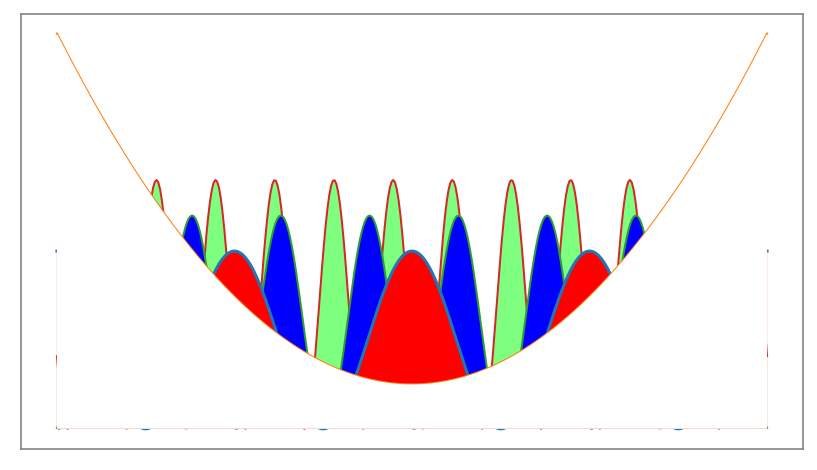

In [253]:
# Create the figure
fig = plt.figure(figsize=(7, 4))
ax = plt.subplot(111)

# remove grid
ax.set_xticks([])
ax.set_yticks([])

# define data 
X = np.linspace(-2*np.pi, 2*np.pi, 400) 

Y1 = X**2/10-0.5
Y2 = np.cos(2*X)
Y3 = 0.2+1.2*np.cos(4*X+3)
Y4 = 0.4+1.4*np.cos(6*X+2)

ax.plot(X, Y2)
ax.fill_between(X, Y1, -1, facecolor=(1,1,1,1), zorder=3)

ax.plot(X, Y1, lw=1)
ax.fill_between(X, Y2, -1, facecolor=(1,0,0,1), zorder=2)


ax.plot(X, Y3, lw=1, zorder=1)
ax.fill_between(X, Y3, -1, facecolor=(0,0,1,1), zorder=1)


ax.plot(X, Y4, lw=1, zorder=0)
ax.fill_between(X, Y4, -1, facecolor=(0,1,0,0.5), zorder=0)

plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 8))

# Add a subplot with no frame
ax = plt.subplot(111) # , frameon=False)
ax.set_xticks([])
ax.set_yticks([])

x = np.arange(0.0, 2, 0.01)
y1 = np.sin(2*np.pi*x)
y2 = 1.2*np.sin(4*np.pi*x)

ax, fig = plt.subplot(111, sharex=True)

ax.plot(x,y1)
# ax.fill_between(x, y1)
ax.set_ylabel('between y1 and 0')
'''
ax.fill_between(x, y1, 1)
ax.set_ylabel('between y1 and 1')

ax3.fill_between(x, y1, y2)
ax3.set_ylabel('between y1 and y2')
ax3.set_xlabel('x')
'''

In [ ]:
# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor=(0,0,0,1))

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (54, 75)) #64
# return 75 evenly spaced numbers between -1 and 1
X = np.linspace(-1, 1, data.shape[-1]) 
G = 1.5 * np.exp(-4 * X ** 2) # each row is a gaussian

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    # see line 307, 
    # https://github.com/sbebo/joypy/blob/master/joypy/joyplot.py
    ax.fill_between(xscale * X, 0.0, i + G * data[i], clip_on=True, facecolor=(0,0,0,1)) # , **kwargs)
    # ax.fill_between(xscale * X, i + G * data[i], facecolor=(0,0,0,1))
    lines.append(line)

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
from joypy import joyplot
%matplotlib inline

fig, ax = joyplot(df)

In [ ]:
from joypy import joyplot
%matplotlib inline

# TimeSeries type error again, I think? we need to input a dataframe instead

#bp_data.to_frame()

fig, axes = joyplot(df, by="event", column="data", ylabels=False, xlabels=False, 
                          grid=False, fill=False, background='k', linecolor="w", linewidth=1,
                          legend=False, overlap=0.5, figsize=(6,5), kind="counts", bins=80)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
for a in axes[:-1]:
    a.set_xlim([-8,8])

### Seaborne Alternative plotting

see: https://seaborn.pydata.org/examples/kde_ridgeplot.html

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [ ]:
fn

In [ ]:
fn

In [ ]:
fn

In [ ]:
fn

In [ ]:
fn

In [ ]:
fn